In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import norm
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from keras.models import Sequential
from keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Flatten, TimeDistributed
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import shap

In [144]:
df = pd.read_csv('Wimbledon_featured_matches.csv')

# data cleaning & preprocessing
df['rally_count'] = df['rally_count'].astype(int)

# convert the elapsed time to seconds
elapsed_seconds = df['elapsed_time'].apply(lambda x: sum(int(a) * 60**index for index, a in enumerate(reversed(x.split(":")))))
df['elapsed_time_sec'] = elapsed_seconds

df.dropna(subset=['speed_mph'],inplace=True)
df.dropna(subset=['serve_width'],inplace=True)
df.dropna(subset=['serve_depth'],inplace=True)

In [3]:
# K-S test for p1_distance_run and p2_distance_run
from scipy.stats import ks_2samp

def ks_test(column_name, list_length = 1000):

    # generate a normal distribution with the same mean and standard deviation of the column we are testing
    mean = df[column_name].mean()
    std = df[column_name].std()
    normal_dist = np.random.normal(mean, std, list_length)

    ks_statistic, p_value = ks_2samp(df[column_name], normal_dist)
    
    return ks_statistic, p_value

In [4]:
for column in ['p1_distance_run', 'p2_distance_run', 'speed_mph', 'rally_count']:
    ks_statistic, p_value = ks_test(column)
    
    # create a table with the results
    print(f'Column: {column}')
    print(f'KS statistic: {ks_statistic}')
    print(f'P value: {p_value}')
    print('')

Column: p1_distance_run
KS statistic: 0.16284624846248463
P value: 1.5255117262791866e-20

Column: p2_distance_run
KS statistic: 0.169079950799508
P value: 4.045153323151518e-22

Column: speed_mph
KS statistic: 0.10387330873308732
P value: 1.3466098767971044e-08

Column: rally_count
KS statistic: 0.232
P value: 1.8915772975965174e-41



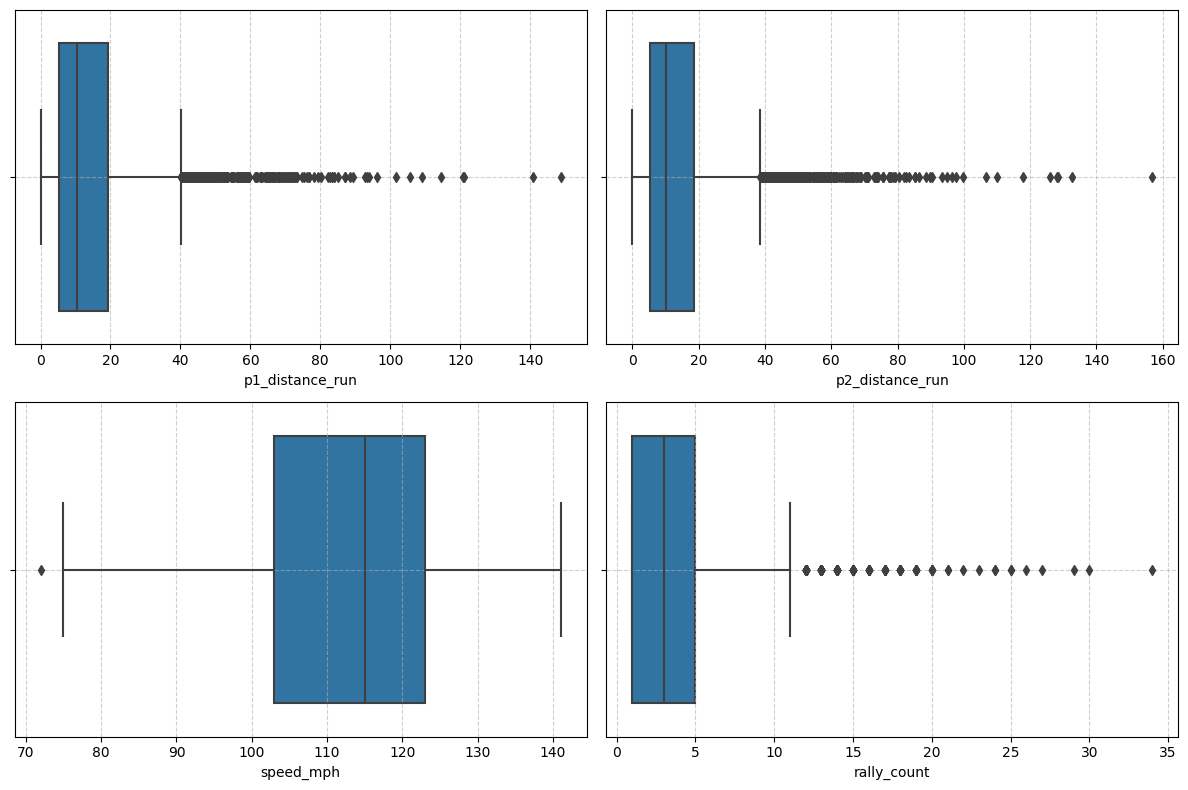

In [5]:
# Use boxplot to detect outliers
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
sns.boxplot(x=df['p1_distance_run'], )
plt.grid(True, linestyle='--', alpha=0.6)
plt.subplot(2, 2, 2)
sns.boxplot(x=df['p2_distance_run'])
plt.grid(True, linestyle='--', alpha=0.6)
plt.subplot(2, 2, 3)
sns.boxplot(x=df['speed_mph'])
plt.grid(True, linestyle='--', alpha=0.6)
plt.subplot(2, 2, 4)
sns.boxplot(x=df['rally_count'])
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

In [145]:
# Remove the row with rally_count > 20
df = df[df['rally_count'] <= 20]

# Remove the row with p1_distance_run > 100
df = df[df['p1_distance_run'] <= 100]

# Remove the row with p2_distance_run > 100
df = df[df['p2_distance_run'] <= 100]

In [146]:
scaler = MinMaxScaler()
df[['p1_distance_run','p2_distance_run','rally_count']] = scaler.fit_transform(df[['p1_distance_run','p2_distance_run','rally_count']])

In [147]:
# Define the features and the target
column_name = ['gameWon','pointLeadG','gameLeadS','setLeadM','ifServing','ace','winner','dFault','unforcedE','netPoints','breakPoints','distanceM','distanceLast3','distanceCur','speed','trueSpeed','rallyCur','rallyLast3','pointsLast3','point_label']

In [9]:
df_1 = df.copy()
df_1.loc[(df_1.p1_score=='AD'),'p1_score'] = 50
df_1.loc[(df_1.p2_score=='AD'),'p2_score'] = 50
df_1['p1_score'] = df_1['p1_score'].astype(int)
df_1['p2_score'] = df_1['p2_score'].astype(int)

In [10]:
data_point_based = pd.DataFrame()
x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10,x_11,x_12,x_13,x_14,x_15,\
    x_16,x_17,x_18,x_19,point_label = [],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]
for match_id,set_no,game_no,point_no in zip(df_1.match_id,df_1.set_no,df_1.game_no,df_1.point_no):
    match = df_1[df_1.match_id==match_id]
    set_ = match[match.set_no==set_no]
    game_ = set_[set_.game_no==game_no]
    point_ = game_[game_.point_no==point_no]

    # x1 is the number of games won by player 1 in the current set
    temp = point_['p1_games'].values[0]
    x_1.append(temp)

    # x2 is the number of point lead by player 1 in the current game
    temp = point_['p1_score'].values[0] - point_['p2_score'].values[0]
    x_2.append(temp)

    # x3 is the number of games lead by player 1 in the current set
    temp = point_['p1_games'].values[0] - point_['p2_games'].values[0]
    x_3.append(temp)

    # x4 is the number of sets lead by player 1 in the current match
    temp = point_['p1_sets'].values[0] - point_['p2_sets'].values[0]
    x_4.append(temp)

    # x5 is 1 if player 1 is serving, 0 otherwise
    temp = 1 if point_['server'].values[0] == 1 else 0
    x_5.append(temp)

    # x6 is the indicator of untouchable winning serve
    temp = 1 if 1 in game_['p1_ace'].values else 0
    x_6.append(temp)

    # x7 is the indicator of untouchable winning shot
    temp = 1 if 1 in game_['p1_winner'].values else 0
    x_7.append(temp)

    # x8 is the indicator of double fault
    temp = 1 if 1 in game_['p1_double_fault'].values else 0
    x_8.append(temp)

    # x9 is the indicator of unforced error
    temp = 1 if 1 in game_['p1_unf_err'].values else 0
    x_9.append(temp)

    # x10 is the ratio of net points won by player 1 in the current game
    temp = game_['p1_net_pt_won'].sum()/game_['p1_net_pt'].sum() if game_['p1_net_pt'].sum()!= 0 else 0
    x_10.append(temp)

    # x11 is the ratio of break points won by player 1 in the current set
    temp = set_['p1_break_pt_won'].sum()/set_['p1_break_pt'].sum() if game_['p1_break_pt'].sum()!= 0 else 0
    x_11.append(temp)

    index = match.index.tolist().index(point_.index.tolist()[0])

    # x12 is the total distance run by player 1 in the current match
    temp = match.iloc[:index+1]['p1_distance_run'].sum()
    x_12.append(temp)

    # x13 is the total distance run by player 1 in last 3 points
    if index>=2:
        temp = match.iloc[index-2:index+1]['p1_distance_run'].sum()
    elif index==1:
        temp = match.iloc[index-2:index+1]['p1_distance_run'].sum()
    else:
        temp = 0
    x_13.append(temp)

    # x14 is the distance run by player 1 in the current point
    temp = point_['p1_distance_run'].values[0]
    x_14.append(temp)

    # x15 is the speed of the last serve by player 1
    temp = point_['speed_mph'].values[0]
    x_15.append(temp)

    # x16 is the product of x3 and x15
    temp = x_3[-1]*x_15[-1]
    x_16.append(temp)

    # x17 is the rally count of the current point
    temp = point_['rally_count'].values[0].astype(int)
    x_17.append(temp)

    # x18 is the rolling average of rally count in the last 3 points
    if index>=2:
        temp = match.iloc[index-2:index+1]['rally_count'].mean()
    elif index==1:
        temp = match.iloc[index-1:index+1]['rally_count'].mean()
    else:
        temp = 0
    x_18.append(temp)

    # x19 is the point won by player 1 in last 3 points
    if index>=2:
        temp = match.iloc[index]['p1_points_won'] - match.iloc[index-2]['p1_points_won']
    elif index==1:
        temp = match.iloc[index]['p1_points_won'] - match.iloc[index-1]['p1_points_won']
    else:
        temp = 0
    x_19.append(temp)
    
    # label is 1 if player 1 won the point, 0 otherwise
    label = 1 if point_['point_victor'].values[0] == 1 else 0
    point_label.append(label)

# assign the features and the target to the dataframe
for i in range(len(column_name)-1):
    data_point_based[column_name[i]] = eval('x_'+ str(i+1))

data_point_based['point_label'] = point_label

In [11]:
columns = data_point_based.columns[:-1]
scaler.fit(data_point_based[columns].values)
data_point_based[columns] = scaler.transform(data_point_based[columns].values)
data_point_based

gameWon  pointLeadG  gameLeadS  setLeadM  ifServing  ace  winner  \
0     0.000000      0.5000   0.555556       0.5        1.0  1.0     1.0   
1     0.000000      0.3125   0.555556       0.5        1.0  1.0     1.0   
2     0.000000      0.5000   0.555556       0.5        1.0  1.0     1.0   
3     0.000000      0.3125   0.555556       0.5        1.0  1.0     1.0   
4     0.000000      0.5000   0.555556       0.5        1.0  1.0     1.0   
...        ...         ...        ...       ...        ...  ...     ...   
6480  0.833333      0.3125   0.666667       0.5        1.0  0.0     1.0   
6481  0.833333      0.5000   0.666667       0.5        1.0  0.0     1.0   
6482  0.833333      0.6875   0.666667       0.5        1.0  0.0     1.0   
6483  0.833333      0.5000   0.666667       0.5        1.0  0.0     1.0   
6484  0.833333      0.6250   0.666667       0.5        1.0  0.0     1.0   

      dFault  unforcedE  netPoints  breakPoints  distanceM  distanceLast3  \
0        0.0        1.0        1.0          0.0   0.000830       0.000000   
1        0.0        1.0        1.0          0.0   0.001663       0.000000   
2        0.0        1.0        1.0          0.0   0.003875       0.150271   
3        0.0        1.0        1.0          0.0   0.012104       0.423782   
4        0.0        1.0        1.0          0.0   0.012195       0.395866   
...      ...        ...        ...          ...        ...            ...   
6480     0.0        1.0        1.0          0.0   0.991328       0.298759   
6481     0.0        1.0        1.0          0.0   0.994142       0.379907   
6482     0.0        1.0        1.0          0.0   0.995883       0.404828   
6483     0.0        1.0        1.0          0.0   0.997141       0.218515   
6484     0.0        1.0        1.0          0.0   1.000000       0.220201   

      distanceCur     speed  trueSpeed  rallyCur  rallyLast3  pointsLast3  \
0        0.061495  0.333333   0.563199       0.0    0.000000          0.0   
1        0.053722  0.666667   0.563199       0.0    0.041667          0.1   
2        0.142655  0.695652   0.563199       0.0    0.111111          0.1   
3        0.530851  0.840580   0.563199       0.0    0.416667          0.1   
4        0.005816  0.579710   0.563199       0.0    0.416667          0.2   
...           ...       ...        ...       ...         ...          ...   
6480     0.400911  0.739130   0.668960       0.0    0.305556          0.1   
6481     0.181498  0.608696   0.661221       0.0    0.416667          0.2   
6482     0.112293  0.753623   0.669819       0.0    0.472222          0.1   
6483     0.081192  0.840580   0.674979       0.0    0.194444          0.1   
6484     0.184390  0.826087   0.674119       0.0    0.138889          0.2   

      point_label  
0               0  
1               1  
2               0  
3               1  
4               1  
...           ...  
6480            1  
6481            1  
6482            0  
6483            1  
6484            1  

[6485 rows x 20 columns]

In [12]:
import warnings
warnings.filterwarnings("ignore")

def validation_score(model):
    acc = round(cross_val_score(model,data_point_based[columns].values,data_point_based['point_label'].values, cv=5,scoring='accuracy').mean(),2)
    recall = round(cross_val_score(model,data_point_based[columns].values,data_point_based['point_label'].values, cv=5,scoring='recall').mean(),2)
    precision = round(cross_val_score(model,data_point_based[columns].values,data_point_based['point_label'].values, cv=5,scoring='precision').mean(),2)
    f1 = round(cross_val_score(model,data_point_based[columns].values,data_point_based['point_label'].values, cv=5,scoring='f1').mean(),2)
    auc = round(cross_val_score(model,data_point_based[columns].values,data_point_based['point_label'].values, cv=5,scoring='roc_auc').mean(),2)

    return acc,recall,precision,f1,auc

# Validation score of different models
model_1 = LGBMClassifier(random_state=30,force_col_wise=True)
print(f'LGBMClassifier acc,recall,precision,f1,auc :{validation_score(model_1)}')
model_2 = xgb.XGBClassifier(random_state=50)
print(f'XGBClassifier acc,recall,precision,f1,auc :{validation_score(model_2)}')
model_3 = SVC(random_state=50)
print(f'SVC acc,recall,precision,f1,auc :{validation_score(model_3)}')
model_4 = MLPClassifier(random_state=50)
print(f'MLPClassifier acc,recall,precision,f1,auc :{validation_score(model_4)}')
model_5 = RandomForestClassifier(random_state=50)
print(f'RandomForestClassifier acc,recall,precision,f1,auc :{validation_score(model_5)}')

[LightGBM] [Info] Number of positive: 2658, number of negative: 2530
[LightGBM] [Info] Total Bins 1175
[LightGBM] [Info] Number of data points in the train set: 5188, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512336 -> initscore=0.049355
[LightGBM] [Info] Start training from score 0.049355
[LightGBM] [Info] Number of positive: 2658, number of negative: 2530
[LightGBM] [Info] Total Bins 1179
[LightGBM] [Info] Number of data points in the train set: 5188, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512336 -> initscore=0.049355
[LightGBM] [Info] Start training from score 0.049355
[LightGBM] [Info] Number of positive: 2658, number of negative: 2530
[LightGBM] [Info] Total Bins 1168
[LightGBM] [Info] Number of data points in the train set: 5188, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.512336 -> initscore=0.049355
[LightGBM] [Info] Start training from score 0.049355
[LightGBM] [Info] N

In [13]:
# get the match_id from the original dataframe
match_id = df['match_id'].unique()
# split the match_id into train and test
train_id, test_id = train_test_split(match_id, test_size=0.2, random_state=50)

# get the index of the train and test data
train_index = df[df['match_id'].isin(train_id)].index
test_index = df[df['match_id'].isin(test_id)].index

# split the data into train and test
train = data_point_based[data_point_based.index.isin(train_index)]
test = data_point_based[data_point_based.index.isin(test_index)]

xtrain = train[columns].values
ytrain = train['point_label'].values
xvalid = test[columns].values
yvalid = test['point_label'].values

# plot the roc_auc curve of different models
model_1.fit(xtrain,ytrain)
model_2.fit(xtrain,ytrain)
model_3.fit(xtrain,ytrain)
model_4.fit(xtrain,ytrain)
model_5.fit(xtrain,ytrain)

[LightGBM] [Info] Number of positive: 2431, number of negative: 2348
[LightGBM] [Info] Total Bins 1168
[LightGBM] [Info] Number of data points in the train set: 4779, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.508684 -> initscore=0.034739
[LightGBM] [Info] Start training from score 0.034739


RandomForestClassifier(random_state=50)

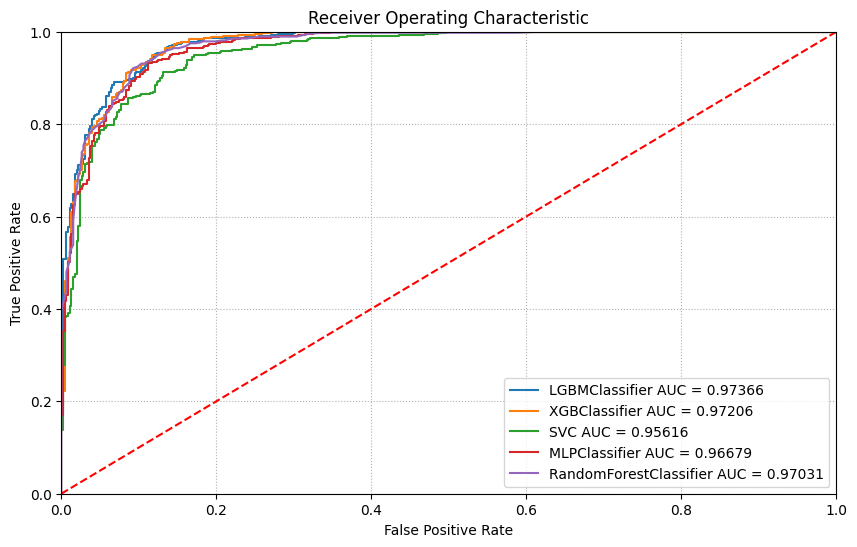

In [14]:
# plot the roc_auc curve of different models
plt.figure(figsize=(10,6))
preds = model_1.predict_proba(xvalid)[:,1]
fpr, tpr, threshold = metrics.roc_curve(yvalid, preds)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, label = 'LGBMClassifier AUC = %0.5f' % roc_auc)

preds = model_2.predict_proba(xvalid)[:,1]
fpr, tpr, threshold = metrics.roc_curve(yvalid, preds)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, label = 'XGBClassifier AUC = %0.5f' % roc_auc)

preds = model_3.decision_function(xvalid)
fpr, tpr, threshold = metrics.roc_curve(yvalid, preds)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, label = 'SVC AUC = %0.5f' % roc_auc)

preds = model_4.predict_proba(xvalid)[:,1]
fpr, tpr, threshold = metrics.roc_curve(yvalid, preds)
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, label = 'MLPClassifier AUC = %0.5f' % roc_auc)

preds = model_5.predict_proba(xvalid)[:,1]
fpr, tpr, threshold = metrics.roc_curve(yvalid, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.plot(fpr, tpr, label = 'RandomForestClassifier AUC = %0.5f' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True, ls=':')
plt.title('Receiver Operating Characteristic')
plt.legend(loc = 'lower right')
plt.show()

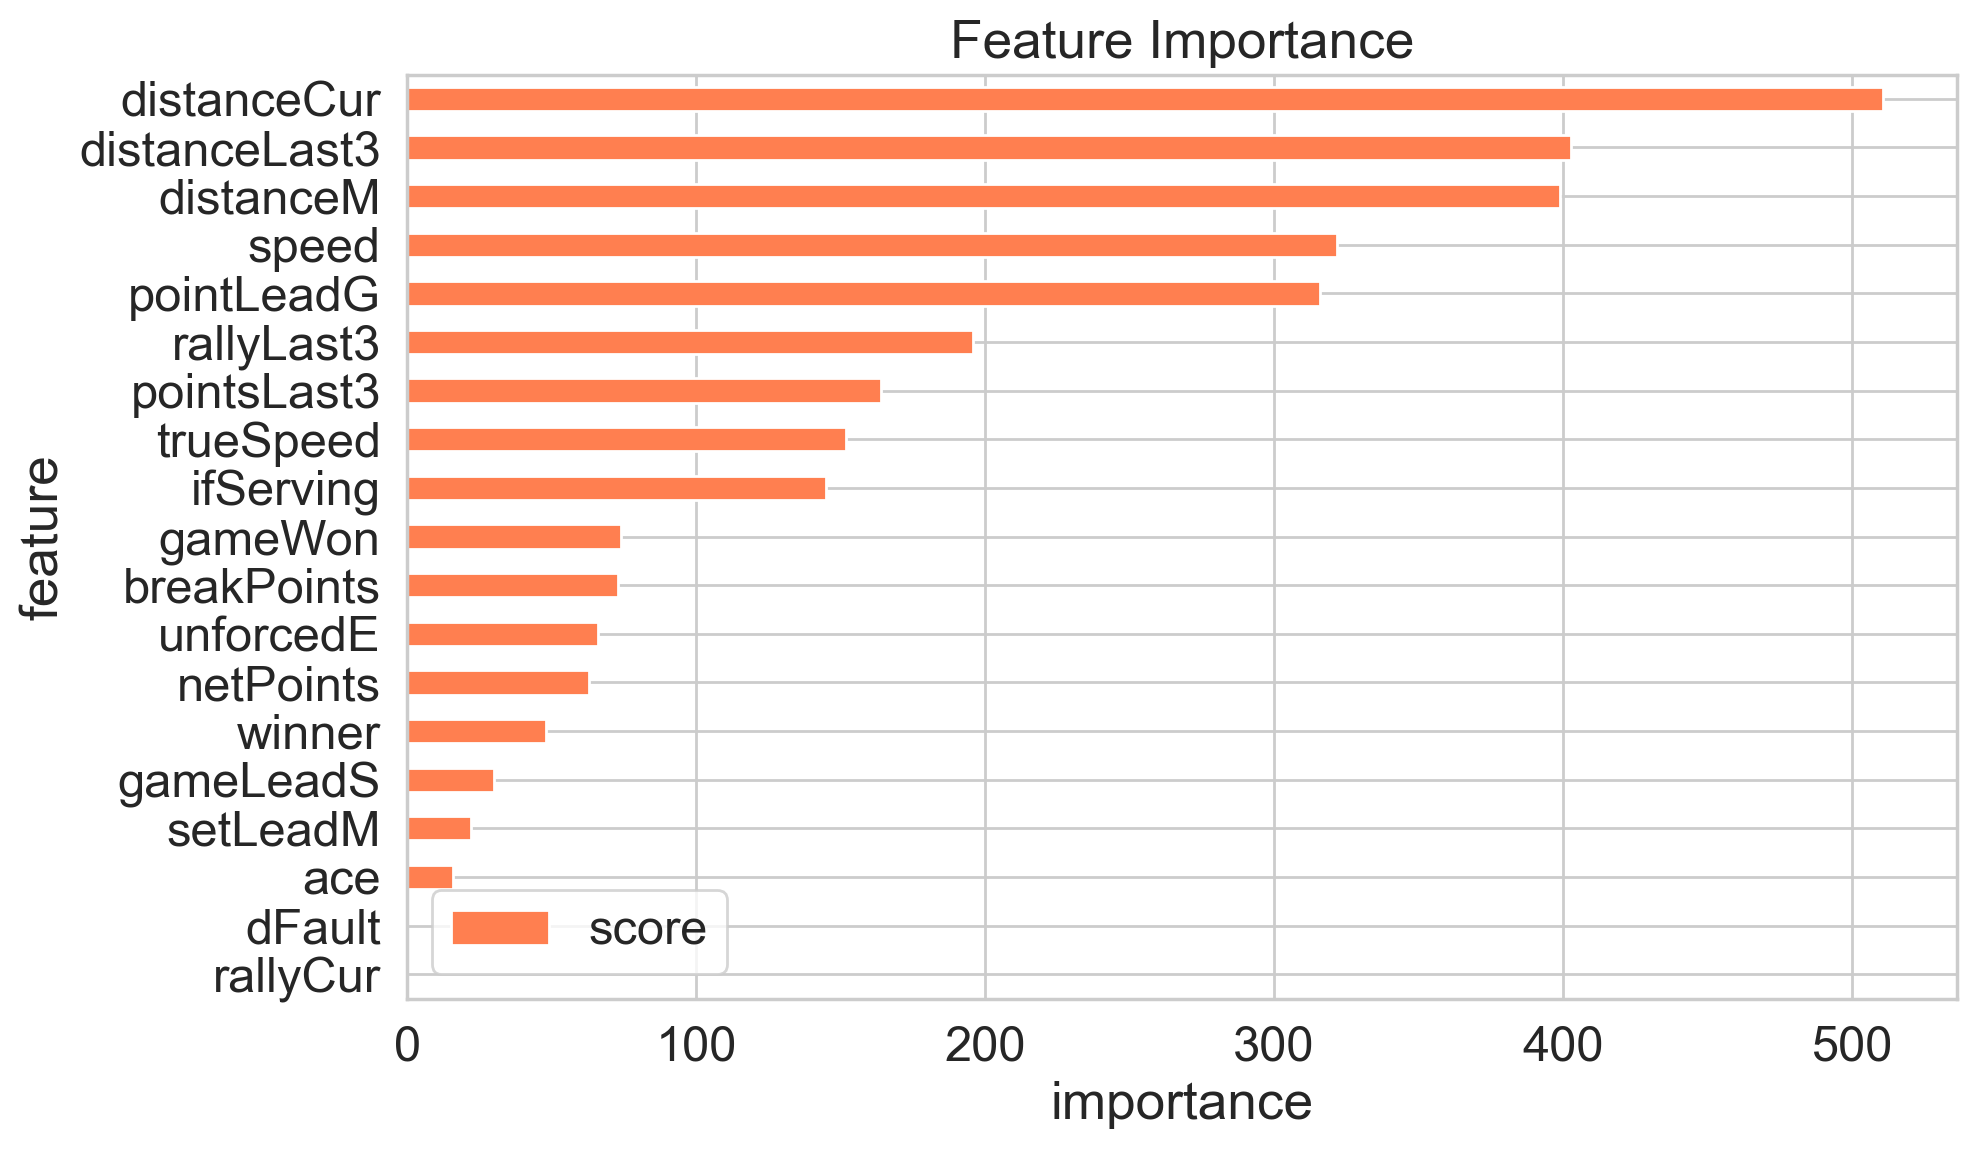

In [15]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline    
import seaborn as sns 
sns.set(style="whitegrid",font_scale=1.6)
import matplotlib
matplotlib.rcParams['axes.unicode_minus']=False
import matplotlib.pyplot as plt
import plotly.express as px

# plot the feature importance horizontal bar plot
f = pd.DataFrame({'col':list(columns),'score':model_1.feature_importances_}).sort_values(by='score',ascending=True)
f.index = f['col']
f = f.drop('col',axis=1)
f.plot(kind='barh',figsize=(10,6), color='coral')
plt.ylabel("feature")
plt.xlabel("importance")
plt.title('Feature Importance')
plt.show()

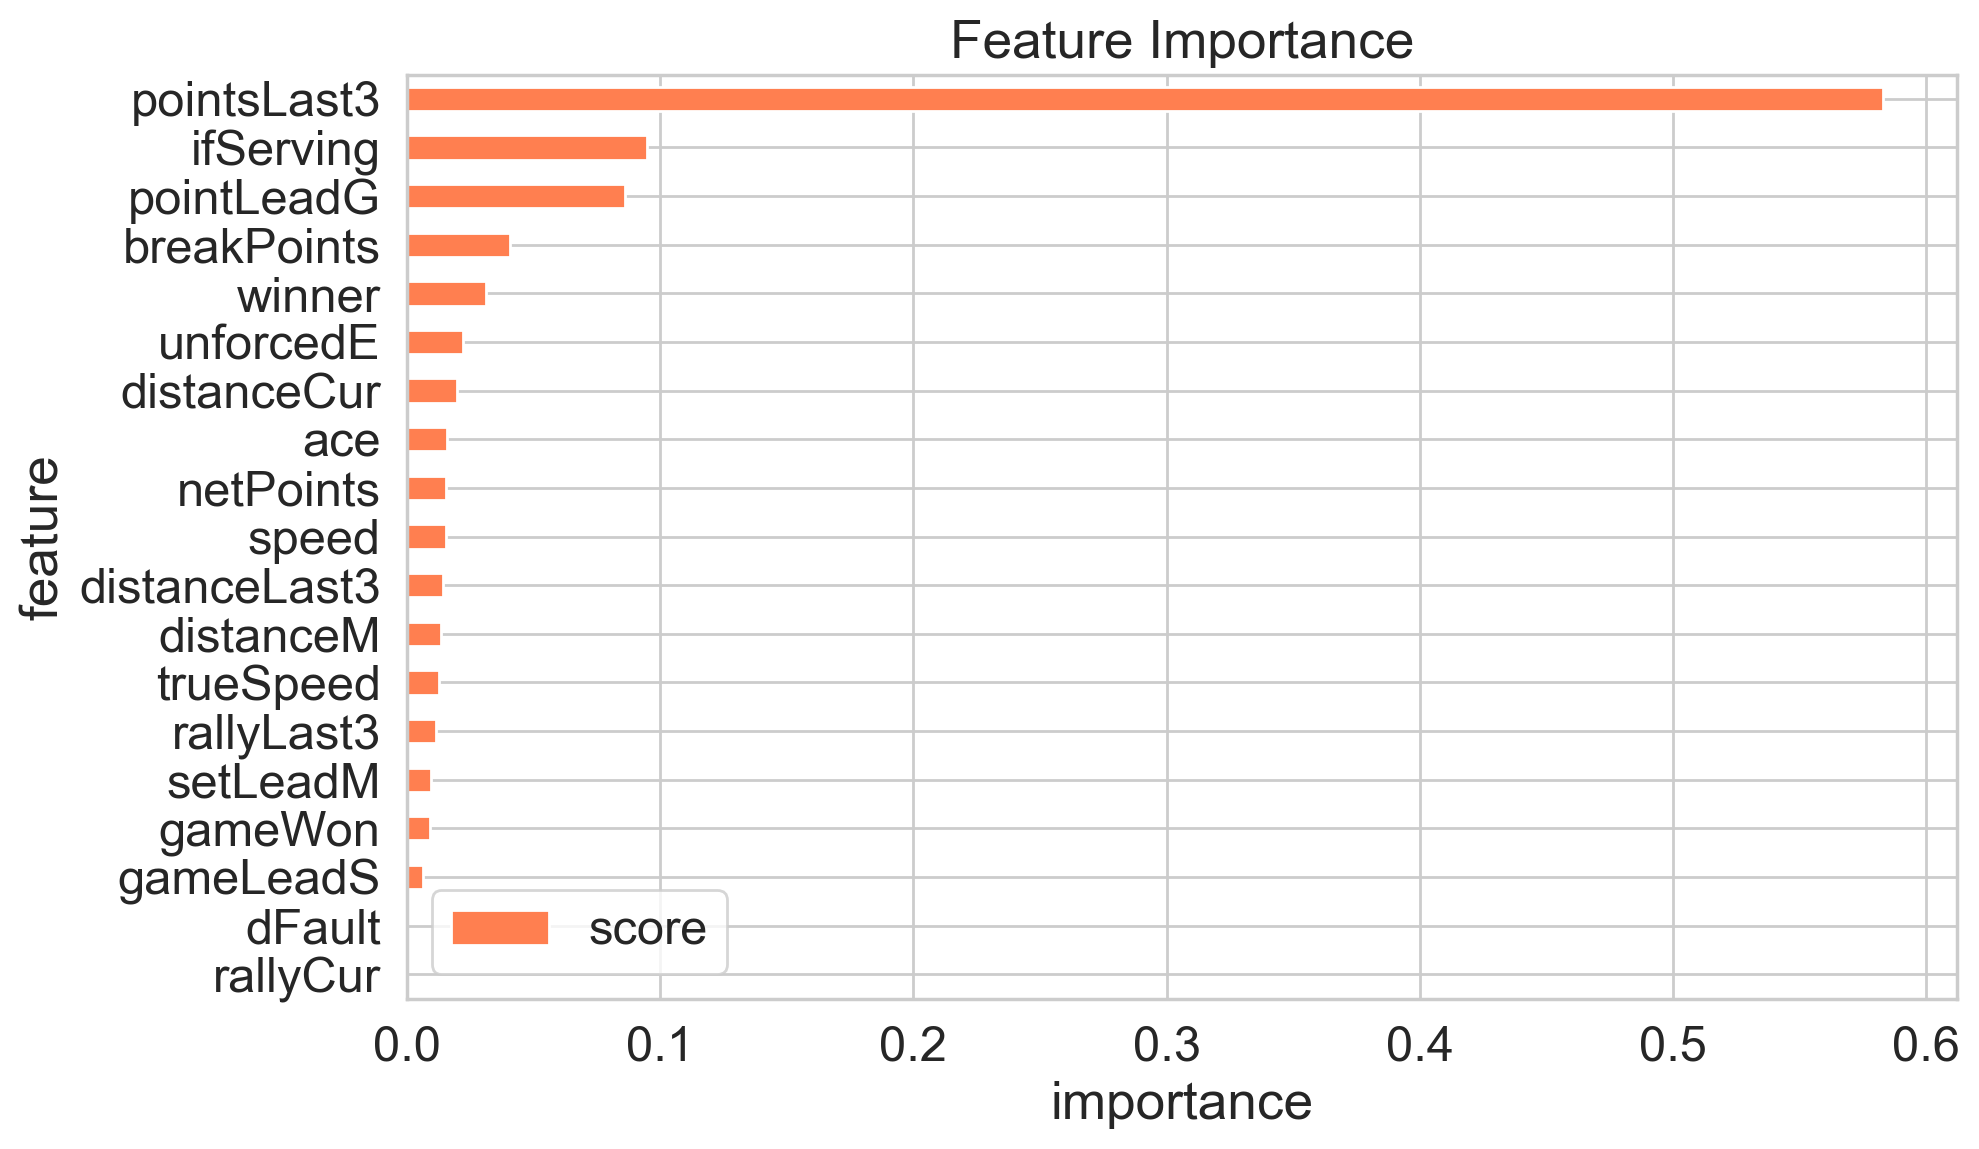

In [16]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline    
import seaborn as sns 
sns.set(style="whitegrid",font_scale=1.6)
import matplotlib
matplotlib.rcParams['axes.unicode_minus']=False
import matplotlib.pyplot as plt
import plotly.express as px

# plot the feature importance horizontal bar plot
f = pd.DataFrame({'col':list(columns),'score':model_2.feature_importances_}).sort_values(by='score',ascending=True)
f.index = f['col']
f = f.drop('col',axis=1)
f.plot(kind='barh',figsize=(10,6), color='coral')
plt.ylabel("feature")
plt.xlabel("importance")
plt.title('Feature Importance')
plt.show()

In [17]:
def calculate_momentum_improved_P1(df, index, lag=3, serve_advantage_weight = 0.2, ace_weight = 0.2, unforced_error_weight = 0.2):
    start_index = max(index - lag, 0)
    end_index = min(index + lag + 1, len(df))

    df_slice = df.iloc[start_index:end_index]

    # Current leading in sets and games
    p1_sets_won = df_slice['p1_sets'].iloc[-1] - df_slice['p1_sets'].iloc[0]
    p1_games_won = df_slice['p1_games'].iloc[-1] - df_slice['p1_games'].iloc[0]

    # Serve advantage
    p1_serve_advantage = (df_slice[df_slice['server'] == 1]['point_victor'] == 1).sum() * serve_advantage_weight

    # Aces
    p1_aces = df_slice['p1_ace'].sum() * ace_weight

    # Unforced errors
    p1_unforced_errors = -df_slice['p1_unf_err'].sum() * unforced_error_weight

    # Other statistics taken into account
    p1_points_advantage = df_slice['point_victor'].apply(lambda x: x == 1).sum() - df_slice['point_victor'].apply(lambda x: x == 2).sum()
    p1_break_points_won = df_slice['p1_break_pt_won'].sum()
    p1_winners = df_slice['p1_winner'].sum()
    p1_distance = df_slice['p1_distance_run'].sum()
    p1_rally_count = df_slice['rally_count'].sum()

    return p1_sets_won, p1_games_won, p1_serve_advantage, p1_points_advantage, p1_break_points_won, p1_unforced_errors, p1_winners, p1_aces, p1_distance, p1_rally_count

def calculate_momentum_improved_P2(df, index, lag=3, serve_advantage_weight = 0.2, ace_weight = 0.2, unforced_error_weight = 0.2):
    start_index = max(index - lag, 0)
    end_index = min(index + lag + 1, len(df))

    df_slice = df.iloc[start_index:end_index]
    
    # Initialize the momentum
    p1_momentum = 0
    p2_momentum = 0

    # Current leading in sets and games
    p1_sets_won = df_slice['p1_sets'].iloc[-1] - df_slice['p1_sets'].iloc[0]
    p2_sets_won = df_slice['p2_sets'].iloc[-1] - df_slice['p2_sets'].iloc[0]
    p1_games_won = df_slice['p1_games'].iloc[-1] - df_slice['p1_games'].iloc[0]
    p2_games_won = df_slice['p2_games'].iloc[-1] - df_slice['p2_games'].iloc[0]

    # Serve advantage
    p1_serve_advantage = (df_slice[df_slice['server'] == 1]['point_victor'] == 1).sum() * serve_advantage_weight
    p2_serve_advantage = (df_slice[df_slice['server'] == 2]['point_victor'] == 2).sum() * serve_advantage_weight

    # Aces
    p1_aces = df_slice['p1_ace'].sum() * ace_weight
    p2_aces = df_slice['p2_ace'].sum() * ace_weight

    # Unforced errors
    p1_unforced_errors = -df_slice['p1_unf_err'].sum() * unforced_error_weight
    p2_unforced_errors = -df_slice['p2_unf_err'].sum() * unforced_error_weight

    # Other statistics taken into account
    p1_points_advantage = df_slice['point_victor'].apply(lambda x: x == 1).sum() - df_slice['point_victor'].apply(lambda x: x == 2).sum()
    p2_points_advantage = -p1_points_advantage
    p1_break_points_won = df_slice['p1_break_pt_won'].sum()
    p2_break_points_won = df_slice['p2_break_pt_won'].sum()
    p1_winners = df_slice['p1_winner'].sum()
    p2_winners = df_slice['p2_winner'].sum()
    p1_distance = df_slice['p1_distance_run'].sum()
    p2_distance = df_slice['p2_distance_run'].sum()
    p1_rally_count = df_slice['rally_count'].sum()
    p2_rally_count = df_slice['rally_count'].sum()

    return p2_sets_won, p2_games_won, p2_serve_advantage, p2_points_advantage, p2_break_points_won, p2_unforced_errors, p2_winners, p2_aces, p2_distance, p2_rally_count

In [18]:
def cumsum_detection(series):

    # Calculate the difference
    diff_series = series.diff().fillna(0)
    
    # Calculate the cumulative sum in different series
    cumsum_series = diff_series.cumsum()
    
    # Detect the turning points
    turning_points = []
    for i in range(1, len(cumsum_series)):
        # If the product of the current and previous value is negative, we have a turning point
        if cumsum_series[i] * cumsum_series[i-1] < 0:
            turning_points.append(i)
    
    return turning_points

In [19]:
def mark_turning_points(data_length, p1_turning_points, p2_turning_points):
    
    turning_points_mark = [0] * data_length
    
    for index in p1_turning_points:
        if index < data_length:
            turning_points_mark[index] = 1
    for index in p2_turning_points:
        if index < data_length:
            turning_points_mark[index] = 1
    
    return turning_points_mark

In [20]:
from scipy.stats import norm

def runs_test(sequence):

    median_value = np.median(sequence)
    binary_sequence = [1 if x > median_value else 0 for x in sequence]

    runs = 1
    for i in range(1, len(binary_sequence)):
        if binary_sequence[i] != binary_sequence[i-1]:
            runs += 1
    
    n1 = binary_sequence.count(1)
    n2 = binary_sequence.count(0)
    expected_runs = 2 * n1 * n2 / (n1 + n2) + 1
    variance = (expected_runs - 1) * (expected_runs - 2) / (n1 + n2 - 1)
    
    Z = (runs - expected_runs) / np.sqrt(variance)
    
    p_value = 2 * (1 - norm.cdf(abs(Z)))
    
    return Z, p_value

In [21]:
def mark_indices_in_list(length, indices):
    
    marked_list = [0] * length
    
    for index in indices:
        if index < length:
            marked_list[index] = 1
            
    return marked_list


def getva(x):
    if x<0.05:
        return 1
    else:
        return 0

In [22]:
def entropy_weight_method(data):
    
    # Standardize the data
    data_normalized = data.apply(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)))
    
    # Calculate the entropy weight
    epsilon = 1e-12 # A small number to avoid log(0)
    p_matrix = data_normalized / data_normalized.sum()
    e_matrix = -np.sum(p_matrix * np.log(p_matrix + epsilon), axis=0) / np.log(len(data))
    
    
    d_matrix = 1 - e_matrix
    
    weights = d_matrix / d_matrix.sum()
    
    return weights

In [23]:
match_id = "2023-wimbledon-1701"
temp = df[df['match_id'] == match_id].copy()
temp.reset_index(inplace=True,drop=True)

In [24]:
momentum_indicator_p1 = [calculate_momentum_improved_P1(temp, index) for index in range(len(temp))]
player1_data=pd.DataFrame(momentum_indicator_p1,columns=['p1_sets_won', 'p1_games_won', 'p1_serve_advantage', 'p1_points_advantage', 'p1_break_points_won', 'p1_unforced_errors', 'p1_winners', 'p1_aces', 'p1_distance', 'p1_rally_count'])

momentum_indicator_p2 = [calculate_momentum_improved_P2(temp, index) for index in range(len(temp))]
player2_data=pd.DataFrame(momentum_indicator_p2,columns=['p2_sets_won', 'p2_games_won', 'p2_serve_advantage', 'p2_points_advantage', 'p2_break_points_won', 'p2_unforced_errors', 'p2_winners', 'p2_aces', 'p2_distance', 'p2_rally_count'])

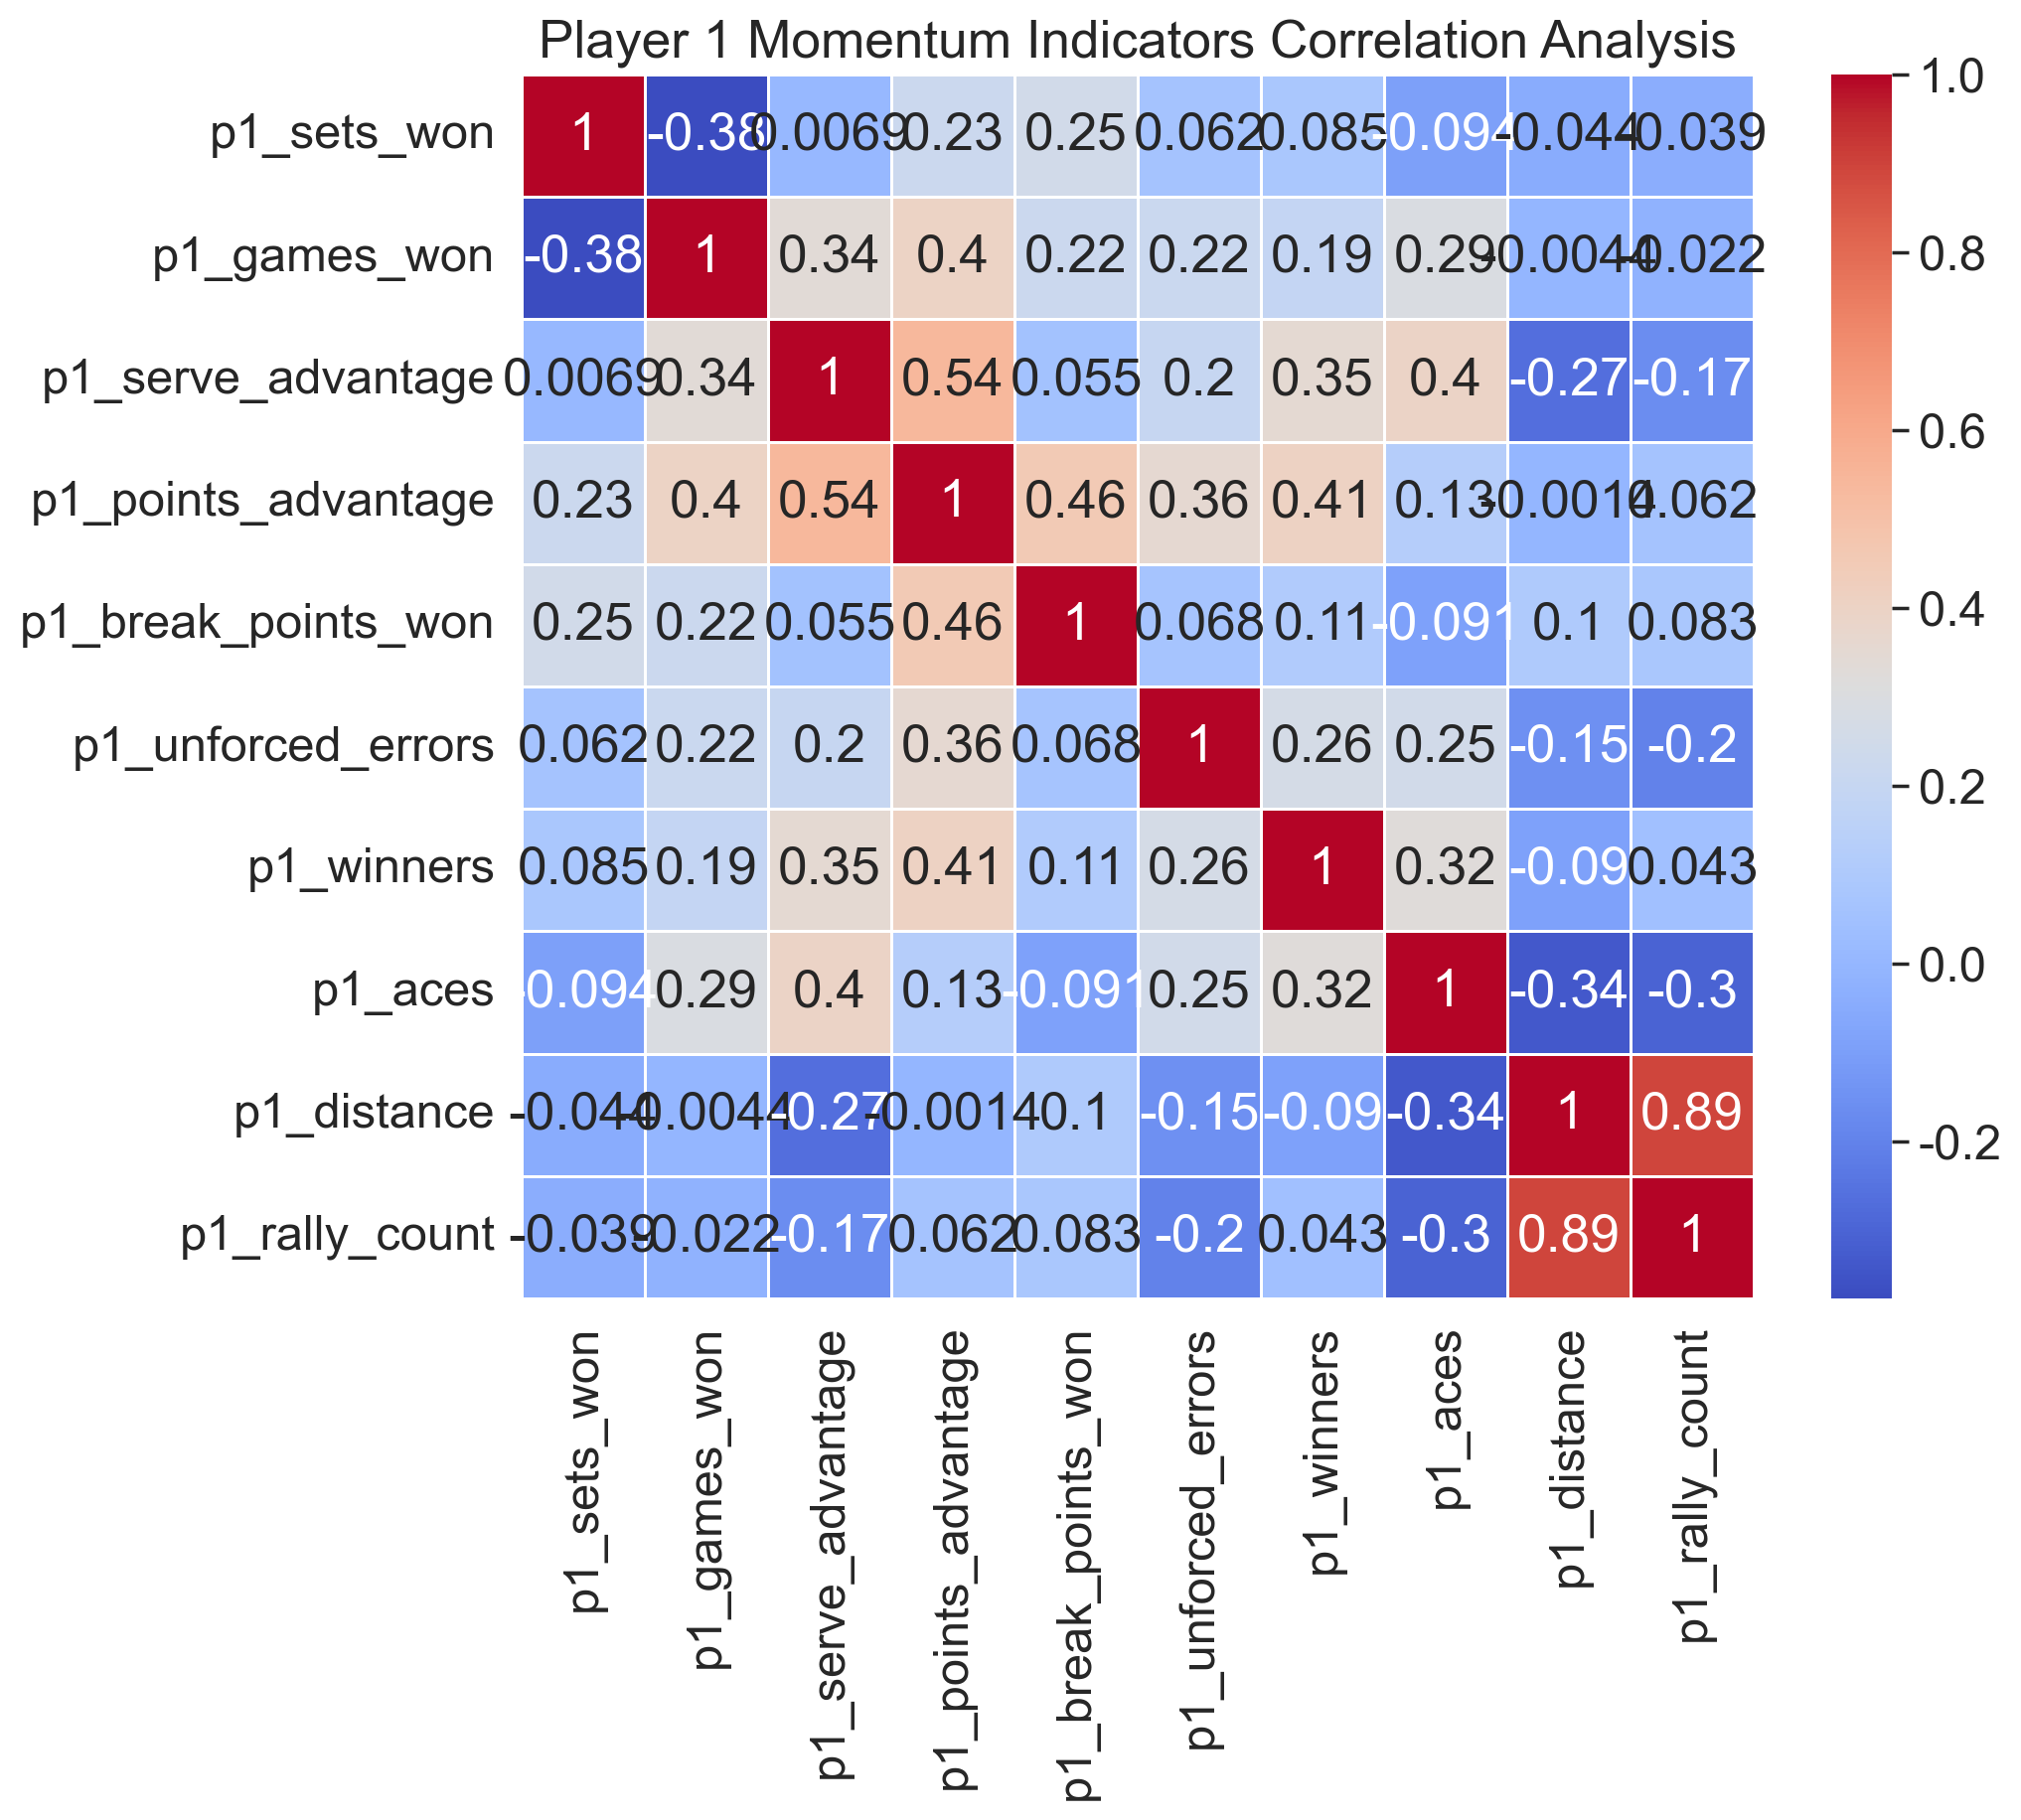

In [25]:
correlation_matrix = player1_data.corr(method= 'spearman')

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Player 1 Momentum Indicators Correlation Analysis')
plt.show()

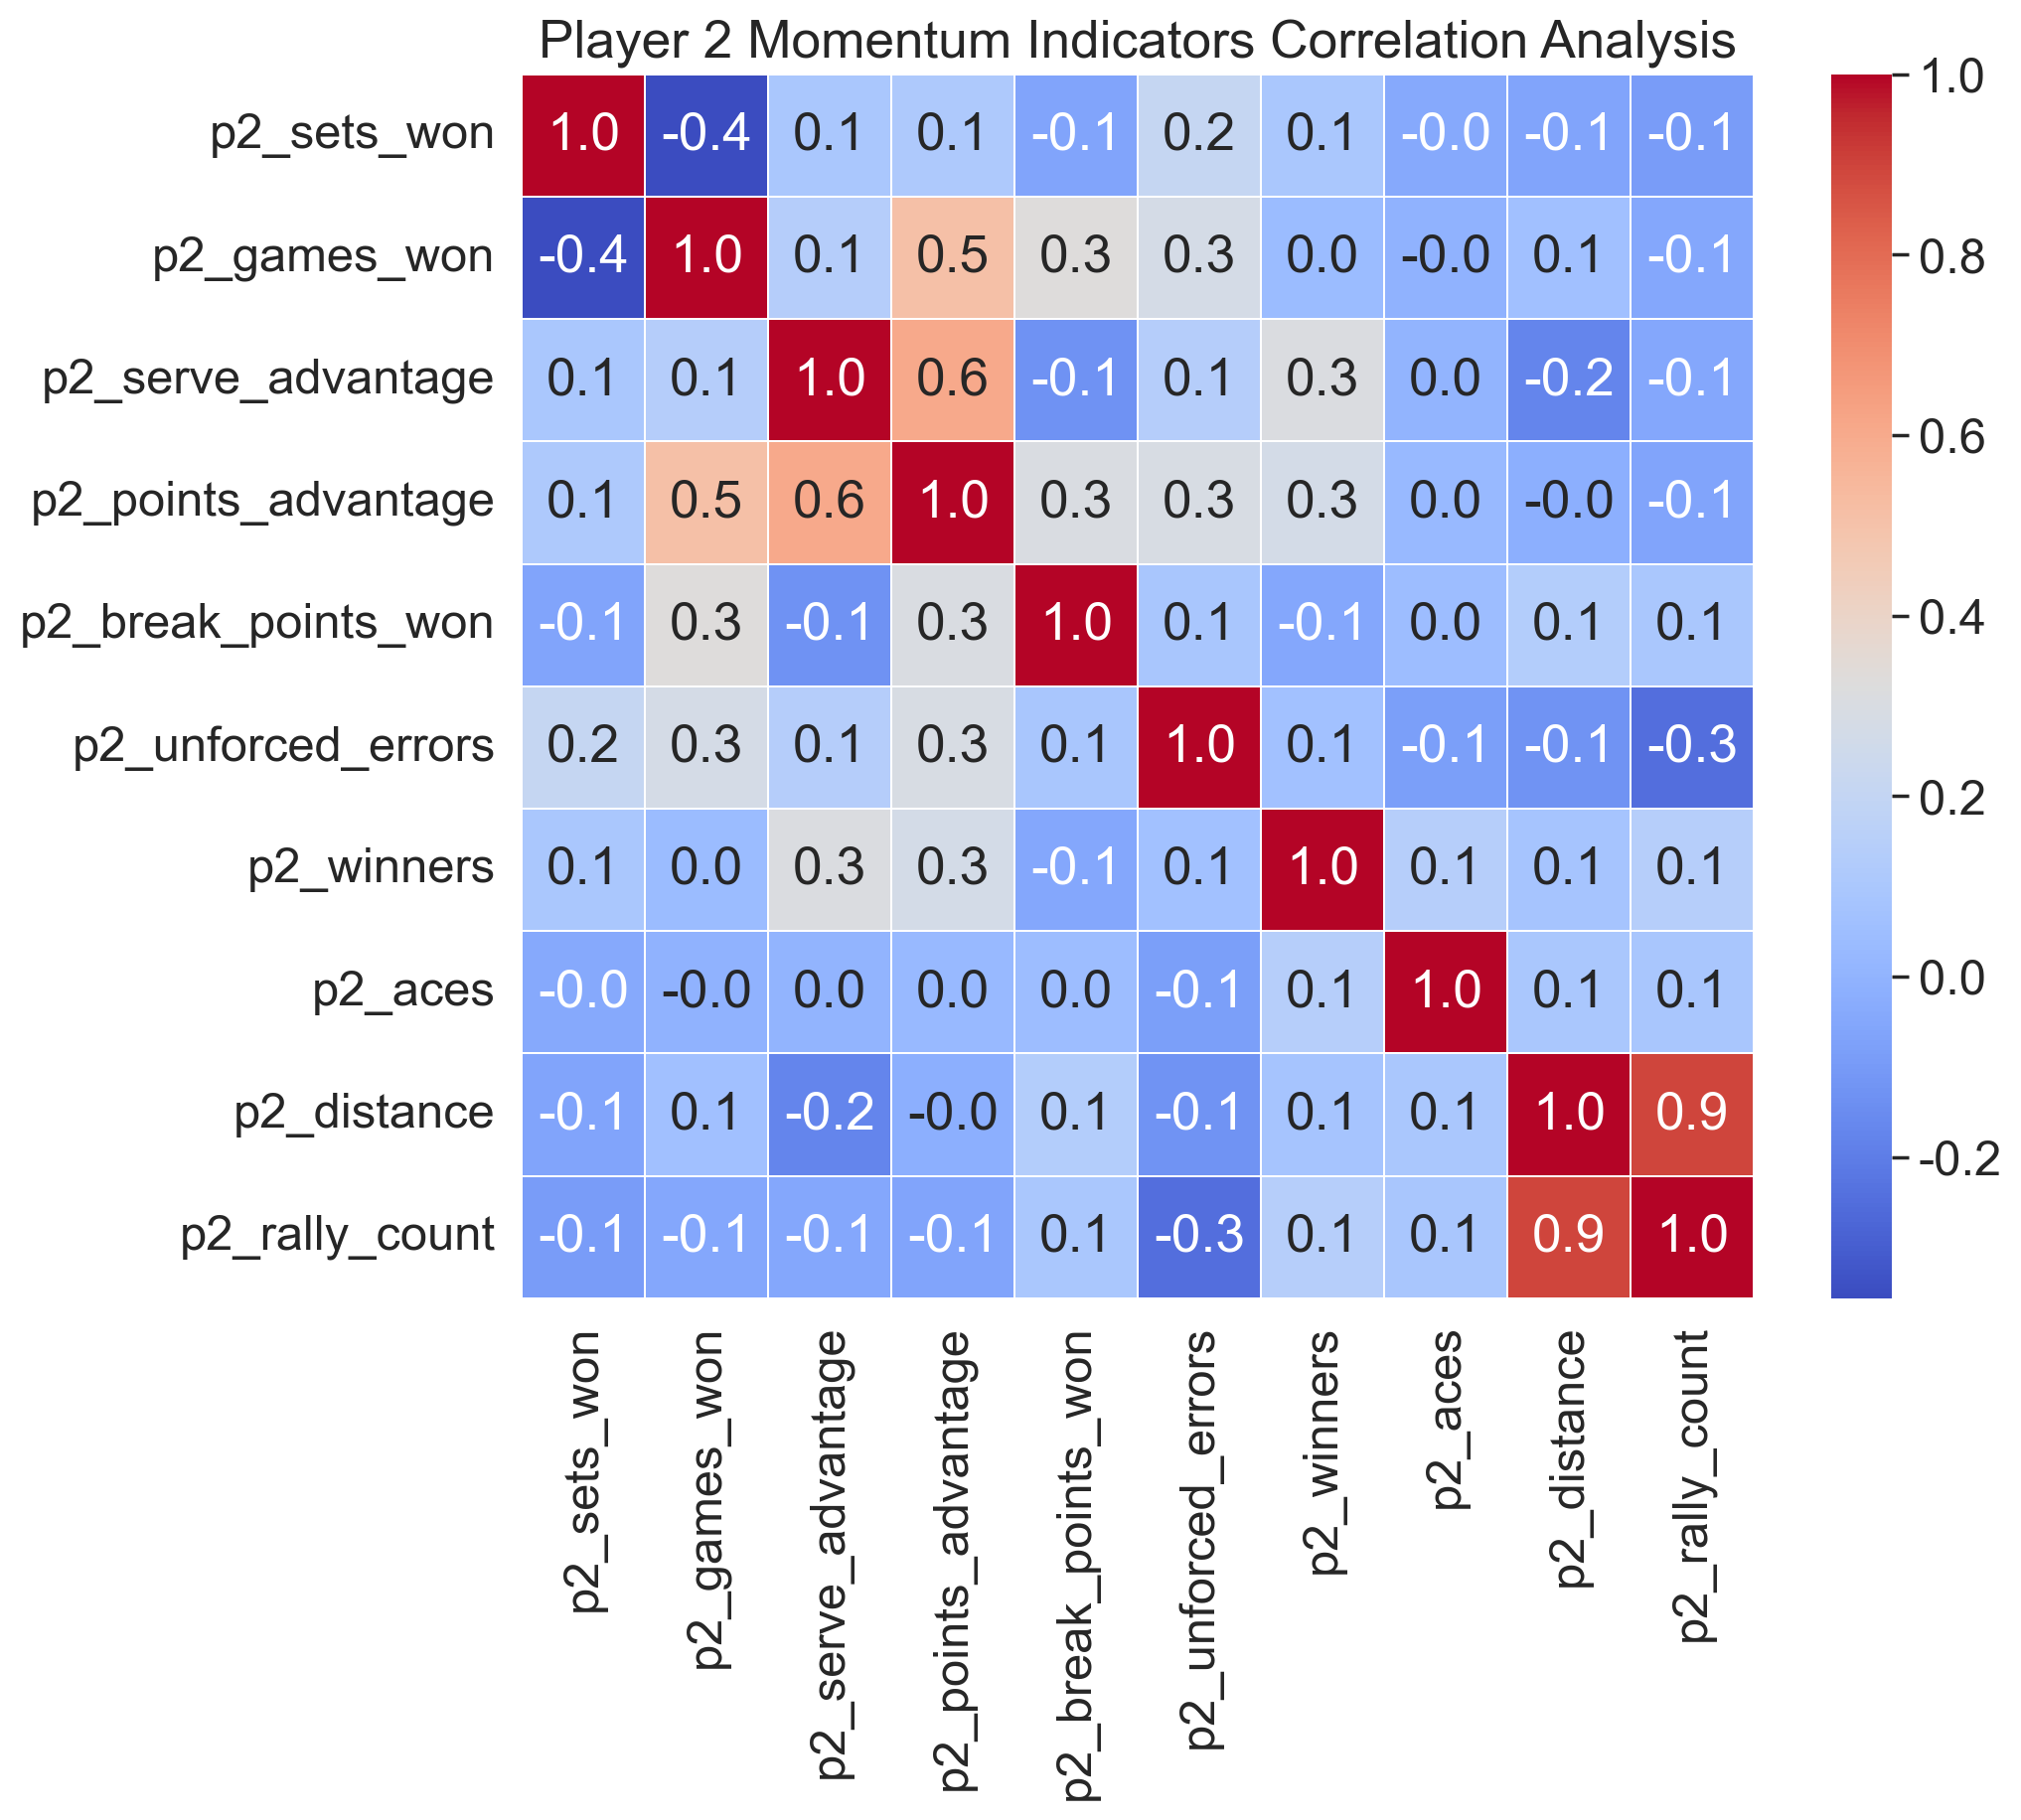

In [62]:
correlation_matrix = player2_data.corr(method= 'spearman')

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.7,fmt=".1f")
plt.title('Player 2 Momentum Indicators Correlation Analysis')
plt.show()

In [152]:
df_momentum=pd.DataFrame()
statistics = []
for match_id in df['match_id'].unique():
    match_data = df[df['match_id'] == match_id].copy()
    match_data.reset_index(inplace=True,drop=True)

    # Calculate the momentum indicators
    momentum_indicator_p1 = [calculate_momentum_improved_P1(match_data, index) for index in range(len(match_data))]
    player1_data=pd.DataFrame(momentum_indicator_p1,columns=['p1_sets_won', 'p1_games_won', 'p1_serve_advantage', 'p1_points_advantage', 'p1_break_points_won', 'p1_unforced_errors', 'p1_winners', 'p1_aces', 'p1_distance', 'p1_rally_count'])

    match_data = pd.concat([match_data, player1_data], axis=1)

    momentum_indicator_p2 = [calculate_momentum_improved_P2(match_data, index) for index in range(len(match_data))]
    player2_data=pd.DataFrame(momentum_indicator_p2,columns=['p2_sets_won', 'p2_games_won', 'p2_serve_advantage', 'p2_points_advantage', 'p2_break_points_won', 'p2_unforced_errors', 'p2_winners', 'p2_aces', 'p2_distance', 'p2_rally_count'])

    match_data = pd.concat([match_data, player2_data], axis=1)
    
    # Calculate the weights
    weights_p1 = entropy_weight_method(player1_data)
    weights_p2 = entropy_weight_method(player2_data)

    # Calculate the weighted sum (momentum)
    player1_score = (player1_data * weights_p1).sum(axis=1)
    player2_score = (player2_data * weights_p2).sum(axis=1)

    match_data['p1_momentum']=pd.DataFrame(player1_score)
    match_data['p2_momentum']=pd.DataFrame(player2_score)

    # Calculate the difference between the two players' momentum
    match_data['momentum_difference'] = match_data['p1_momentum'] - match_data['p2_momentum']

    # Calculate the turning points
    p1_turning_points = cumsum_detection(match_data['p1_momentum'])
    p2_turning_points = cumsum_detection(match_data['p2_momentum'])

    list_length=len(match_data)
    p1_turning_points = mark_indices_in_list(list_length, p1_turning_points)
    p2_turning_points = mark_indices_in_list(list_length, p2_turning_points)

    Z_statistic, p_value1 = runs_test(player1_score)
    Z_statistic, p_value2 = runs_test(player2_score)
    Z_statistic, p_value3 = runs_test(p1_turning_points)
    Z_statistic, p_value4 = runs_test(p2_turning_points)

    df_momentum = pd.concat([df_momentum,match_data],axis=0)
    statistics.append([match_id,getva(p_value1),getva(p_value2),getva(p_value3),getva(p_value4)])

In [153]:
statistics = pd.DataFrame(statistics,columns=['match_id','p1_momentumisRand','p2_momentumisRand','p1_turning_pointsisRand','p2_turning_pointsisRand'])
statistics

match_id  p1_momentumisRand  p2_momentumisRand  \
0   2023-wimbledon-1301                  1                  1   
1   2023-wimbledon-1302                  1                  1   
2   2023-wimbledon-1303                  1                  1   
3   2023-wimbledon-1304                  1                  1   
4   2023-wimbledon-1305                  1                  1   
5   2023-wimbledon-1306                  1                  1   
6   2023-wimbledon-1307                  1                  1   
7   2023-wimbledon-1308                  1                  1   
8   2023-wimbledon-1309                  1                  1   
9   2023-wimbledon-1312                  1                  1   
10  2023-wimbledon-1313                  1                  1   
11  2023-wimbledon-1314                  1                  1   
12  2023-wimbledon-1315                  1                  1   
13  2023-wimbledon-1316                  1                  1   
14  2023-wimbledon-1401                  1                  1   
15  2023-wimbledon-1402                  1                  1   
16  2023-wimbledon-1403                  1                  1   
17  2023-wimbledon-1404                  1                  1   
18  2023-wimbledon-1405                  1                  1   
19  2023-wimbledon-1406                  1                  1   
20  2023-wimbledon-1407                  1                  1   
21  2023-wimbledon-1408                  1                  1   
22  2023-wimbledon-1501                  1                  1   
23  2023-wimbledon-1502                  1                  1   
24  2023-wimbledon-1503                  1                  1   
25  2023-wimbledon-1504                  1                  1   
26  2023-wimbledon-1601                  1                  1   
27  2023-wimbledon-1602                  1                  1   
28  2023-wimbledon-1701                  1                  1   

    p1_turning_pointsisRand  p2_turning_pointsisRand  
0                         0                        1  
1                         0                        1  
2                         0                        0  
3                         0                        1  
4                         1                        0  
5                         0                        0  
6                         0                        1  
7                         0                        0  
8                         1                        1  
9                         0                        0  
10                        0                        1  
11                        0                        0  
12                        0                        0  
13                        1                        0  
14                        1                        0  
15                        0                        1  
16                        0                        0  
17                        1                        0  
18                        1                        0  
19                        1                        0  
20                        0                        0  
21                        0                        1  
22                        1                        0  
23                        1                        1  
24                        1                        0  
25                        0                        0  
26                        0                        1  
27                        1                        1  
28                        0                        0

In [154]:
statistics.describe()

p1_momentumisRand  p2_momentumisRand  p1_turning_pointsisRand  \
count               29.0               29.0                29.000000   
mean                 1.0                1.0                 0.379310   
std                  0.0                0.0                 0.493804   
min                  1.0                1.0                 0.000000   
25%                  1.0                1.0                 0.000000   
50%                  1.0                1.0                 0.000000   
75%                  1.0                1.0                 1.000000   
max                  1.0                1.0                 1.000000   

       p2_turning_pointsisRand  
count                29.000000  
mean                  0.379310  
std                   0.493804  
min                   0.000000  
25%                   0.000000  
50%                   0.000000  
75%                   1.000000  
max                   1.000000

In [30]:
df_momentum.reset_index(drop=True,inplace=True)
df_momentum

match_id         player1         player2 elapsed_time  \
0     2023-wimbledon-1301  Carlos Alcaraz   Nicolas Jarry     00:00:00   
1     2023-wimbledon-1301  Carlos Alcaraz   Nicolas Jarry     00:00:38   
2     2023-wimbledon-1301  Carlos Alcaraz   Nicolas Jarry     00:01:01   
3     2023-wimbledon-1301  Carlos Alcaraz   Nicolas Jarry     00:01:31   
4     2023-wimbledon-1301  Carlos Alcaraz   Nicolas Jarry     00:02:21   
...                   ...             ...             ...          ...   
6480  2023-wimbledon-1701  Carlos Alcaraz  Novak Djokovic     04:39:58   
6481  2023-wimbledon-1701  Carlos Alcaraz  Novak Djokovic     04:40:43   
6482  2023-wimbledon-1701  Carlos Alcaraz  Novak Djokovic     04:41:20   
6483  2023-wimbledon-1701  Carlos Alcaraz  Novak Djokovic     04:41:52   
6484  2023-wimbledon-1701  Carlos Alcaraz  Novak Djokovic     04:42:27   

      set_no  game_no  point_no  p1_sets  p2_sets  p1_games  ...  \
0          1        1         1        0        0         0  ...   
1          1        1         2        0        0         0  ...   
2          1        1         3        0        0         0  ...   
3          1        1         4        0        0         0  ...   
4          1        1         5        0        0         0  ...   
...      ...      ...       ...      ...      ...       ...  ...   
6480       5       10       330        2        2         5  ...   
6481       5       10       331        2        2         5  ...   
6482       5       10       332        2        2         5  ...   
6483       5       10       333        2        2         5  ...   
6484       5       10       334        2        2         5  ...   

      p2_serve_advantage p2_points_advantage p2_break_points_won  \
0                    0.0                   0                   0   
1                    0.0                  -1                   0   
2                    0.0                   0                   0   
3                    0.0                  -1                   0   
4                    0.0                  -1                   0   
...                  ...                 ...                 ...   
6480                 0.2                  -1                   0   
6481                 0.2                  -1                   0   
6482                 0.0                  -2                   0   
6483                 0.0                  -3                   0   
6484                 0.0                  -2                   0   

      p2_unforced_errors  p2_winners  p2_aces  p2_distance  p2_rally_count  \
0                    0.0           0      0.0     1.144948        0.842105   
1                    0.0           0      0.0     1.153382        0.842105   
2                    0.0           0      0.0     1.197459        0.894737   
3                    0.0           0      0.0     1.382324        0.894737   
4                    0.0           1      0.0     1.488413        1.105263   
...                  ...         ...      ...          ...             ...   
6480                 0.0           1      0.0     1.329575        1.000000   
6481                 0.0           1      0.0     1.523662        1.052632   
6482                 0.0           1      0.0     1.486224        1.052632   
6483                 0.0           1      0.0     1.379346        1.000000   
6484                 0.0           1      0.0     0.850602        0.473684   

      p1_momentum  p2_momentum  
0        0.093343     0.020962  
1        0.206826     0.013676  
2        0.201867     0.022111  
3        0.316151     0.016316  
4        0.322319     0.060254  
...           ...          ...  
6480     0.145122     0.080071  
6481     0.153872     0.082380  
6482     0.167501     0.060882  
6483     0.182961     0.046578  
6484     0.106977     0.049493  

[6485 rows x 69 columns]

In [31]:
# Get the data for the final match
match_id = "2023-wimbledon-1701"
temp=df_momentum[df_momentum['match_id'] == match_id].copy()
temp

match_id         player1         player2 elapsed_time  \
6164  2023-wimbledon-1701  Carlos Alcaraz  Novak Djokovic     00:00:00   
6165  2023-wimbledon-1701  Carlos Alcaraz  Novak Djokovic     00:00:25   
6166  2023-wimbledon-1701  Carlos Alcaraz  Novak Djokovic     00:01:19   
6167  2023-wimbledon-1701  Carlos Alcaraz  Novak Djokovic     00:02:17   
6168  2023-wimbledon-1701  Carlos Alcaraz  Novak Djokovic     00:03:02   
...                   ...             ...             ...          ...   
6480  2023-wimbledon-1701  Carlos Alcaraz  Novak Djokovic     04:39:58   
6481  2023-wimbledon-1701  Carlos Alcaraz  Novak Djokovic     04:40:43   
6482  2023-wimbledon-1701  Carlos Alcaraz  Novak Djokovic     04:41:20   
6483  2023-wimbledon-1701  Carlos Alcaraz  Novak Djokovic     04:41:52   
6484  2023-wimbledon-1701  Carlos Alcaraz  Novak Djokovic     04:42:27   

      set_no  game_no  point_no  p1_sets  p2_sets  p1_games  ...  \
6164       1        1         1        0        0         0  ...   
6165       1        1         2        0        0         0  ...   
6166       1        1         3        0        0         0  ...   
6167       1        1         4        0        0         0  ...   
6168       1        1         5        0        0         0  ...   
...      ...      ...       ...      ...      ...       ...  ...   
6480       5       10       330        2        2         5  ...   
6481       5       10       331        2        2         5  ...   
6482       5       10       332        2        2         5  ...   
6483       5       10       333        2        2         5  ...   
6484       5       10       334        2        2         5  ...   

      p2_serve_advantage p2_points_advantage p2_break_points_won  \
6164                 0.4                   0                   0   
6165                 0.4                  -1                   0   
6166                 0.6                   0                   0   
6167                 0.8                   1                   0   
6168                 0.6                  -1                   0   
...                  ...                 ...                 ...   
6480                 0.2                  -1                   0   
6481                 0.2                  -1                   0   
6482                 0.0                  -2                   0   
6483                 0.0                  -3                   0   
6484                 0.0                  -2                   0   

      p2_unforced_errors  p2_winners  p2_aces  p2_distance  p2_rally_count  \
6164                 0.0           0      0.0     0.350446        0.210526   
6165                -0.2           0      0.0     0.440446        0.263158   
6166                -0.2           0      0.0     0.520363        0.263158   
6167                -0.2           1      0.0     0.722967        0.473684   
6168                -0.2           1      0.0     0.932915        0.736842   
...                  ...         ...      ...          ...             ...   
6480                 0.0           1      0.0     1.329575        1.000000   
6481                 0.0           1      0.0     1.523662        1.052632   
6482                 0.0           1      0.0     1.486224        1.052632   
6483                 0.0           1      0.0     1.379346        1.000000   
6484                 0.0           1      0.0     0.850602        0.473684   

      p1_momentum  p2_momentum  
6164     0.049797     0.013809  
6165     0.065809     0.000236  
6166     0.052511     0.018069  
6167     0.043319     0.101737  
6168     0.076306     0.076280  
...           ...          ...  
6480     0.145122     0.080071  
6481     0.153872     0.082380  
6482     0.167501     0.060882  
6483     0.182961     0.046578  
6484     0.106977     0.049493  

[321 rows x 69 columns]

In [32]:
# drop unnecessary columns
temp.reset_index(inplace=True,drop=True)
temp.fillna(method='backfill',inplace=True)
temp.isnull().sum()

match_id          0
player1           0
player2           0
elapsed_time      0
set_no            0
                 ..
p2_aces           0
p2_distance       0
p2_rally_count    0
p1_momentum       0
p2_momentum       0
Length: 69, dtype: int64

In [33]:
temp

match_id         player1         player2 elapsed_time  set_no  \
0    2023-wimbledon-1701  Carlos Alcaraz  Novak Djokovic     00:00:00       1   
1    2023-wimbledon-1701  Carlos Alcaraz  Novak Djokovic     00:00:25       1   
2    2023-wimbledon-1701  Carlos Alcaraz  Novak Djokovic     00:01:19       1   
3    2023-wimbledon-1701  Carlos Alcaraz  Novak Djokovic     00:02:17       1   
4    2023-wimbledon-1701  Carlos Alcaraz  Novak Djokovic     00:03:02       1   
..                   ...             ...             ...          ...     ...   
316  2023-wimbledon-1701  Carlos Alcaraz  Novak Djokovic     04:39:58       5   
317  2023-wimbledon-1701  Carlos Alcaraz  Novak Djokovic     04:40:43       5   
318  2023-wimbledon-1701  Carlos Alcaraz  Novak Djokovic     04:41:20       5   
319  2023-wimbledon-1701  Carlos Alcaraz  Novak Djokovic     04:41:52       5   
320  2023-wimbledon-1701  Carlos Alcaraz  Novak Djokovic     04:42:27       5   

     game_no  point_no  p1_sets  p2_sets  p1_games  ...  p2_serve_advantage  \
0          1         1        0        0         0  ...                 0.4   
1          1         2        0        0         0  ...                 0.4   
2          1         3        0        0         0  ...                 0.6   
3          1         4        0        0         0  ...                 0.8   
4          1         5        0        0         0  ...                 0.6   
..       ...       ...      ...      ...       ...  ...                 ...   
316       10       330        2        2         5  ...                 0.2   
317       10       331        2        2         5  ...                 0.2   
318       10       332        2        2         5  ...                 0.0   
319       10       333        2        2         5  ...                 0.0   
320       10       334        2        2         5  ...                 0.0   

    p2_points_advantage p2_break_points_won  p2_unforced_errors  p2_winners  \
0                     0                   0                 0.0           0   
1                    -1                   0                -0.2           0   
2                     0                   0                -0.2           0   
3                     1                   0                -0.2           1   
4                    -1                   0                -0.2           1   
..                  ...                 ...                 ...         ...   
316                  -1                   0                 0.0           1   
317                  -1                   0                 0.0           1   
318                  -2                   0                 0.0           1   
319                  -3                   0                 0.0           1   
320                  -2                   0                 0.0           1   

     p2_aces  p2_distance  p2_rally_count  p1_momentum  p2_momentum  
0        0.0     0.350446        0.210526     0.049797     0.013809  
1        0.0     0.440446        0.263158     0.065809     0.000236  
2        0.0     0.520363        0.263158     0.052511     0.018069  
3        0.0     0.722967        0.473684     0.043319     0.101737  
4        0.0     0.932915        0.736842     0.076306     0.076280  
..       ...          ...             ...          ...          ...  
316      0.0     1.329575        1.000000     0.145122     0.080071  
317      0.0     1.523662        1.052632     0.153872     0.082380  
318      0.0     1.486224        1.052632     0.167501     0.060882  
319      0.0     1.379346        1.000000     0.182961     0.046578  
320      0.0     0.850602        0.473684     0.106977     0.049493  

[321 rows x 69 columns]

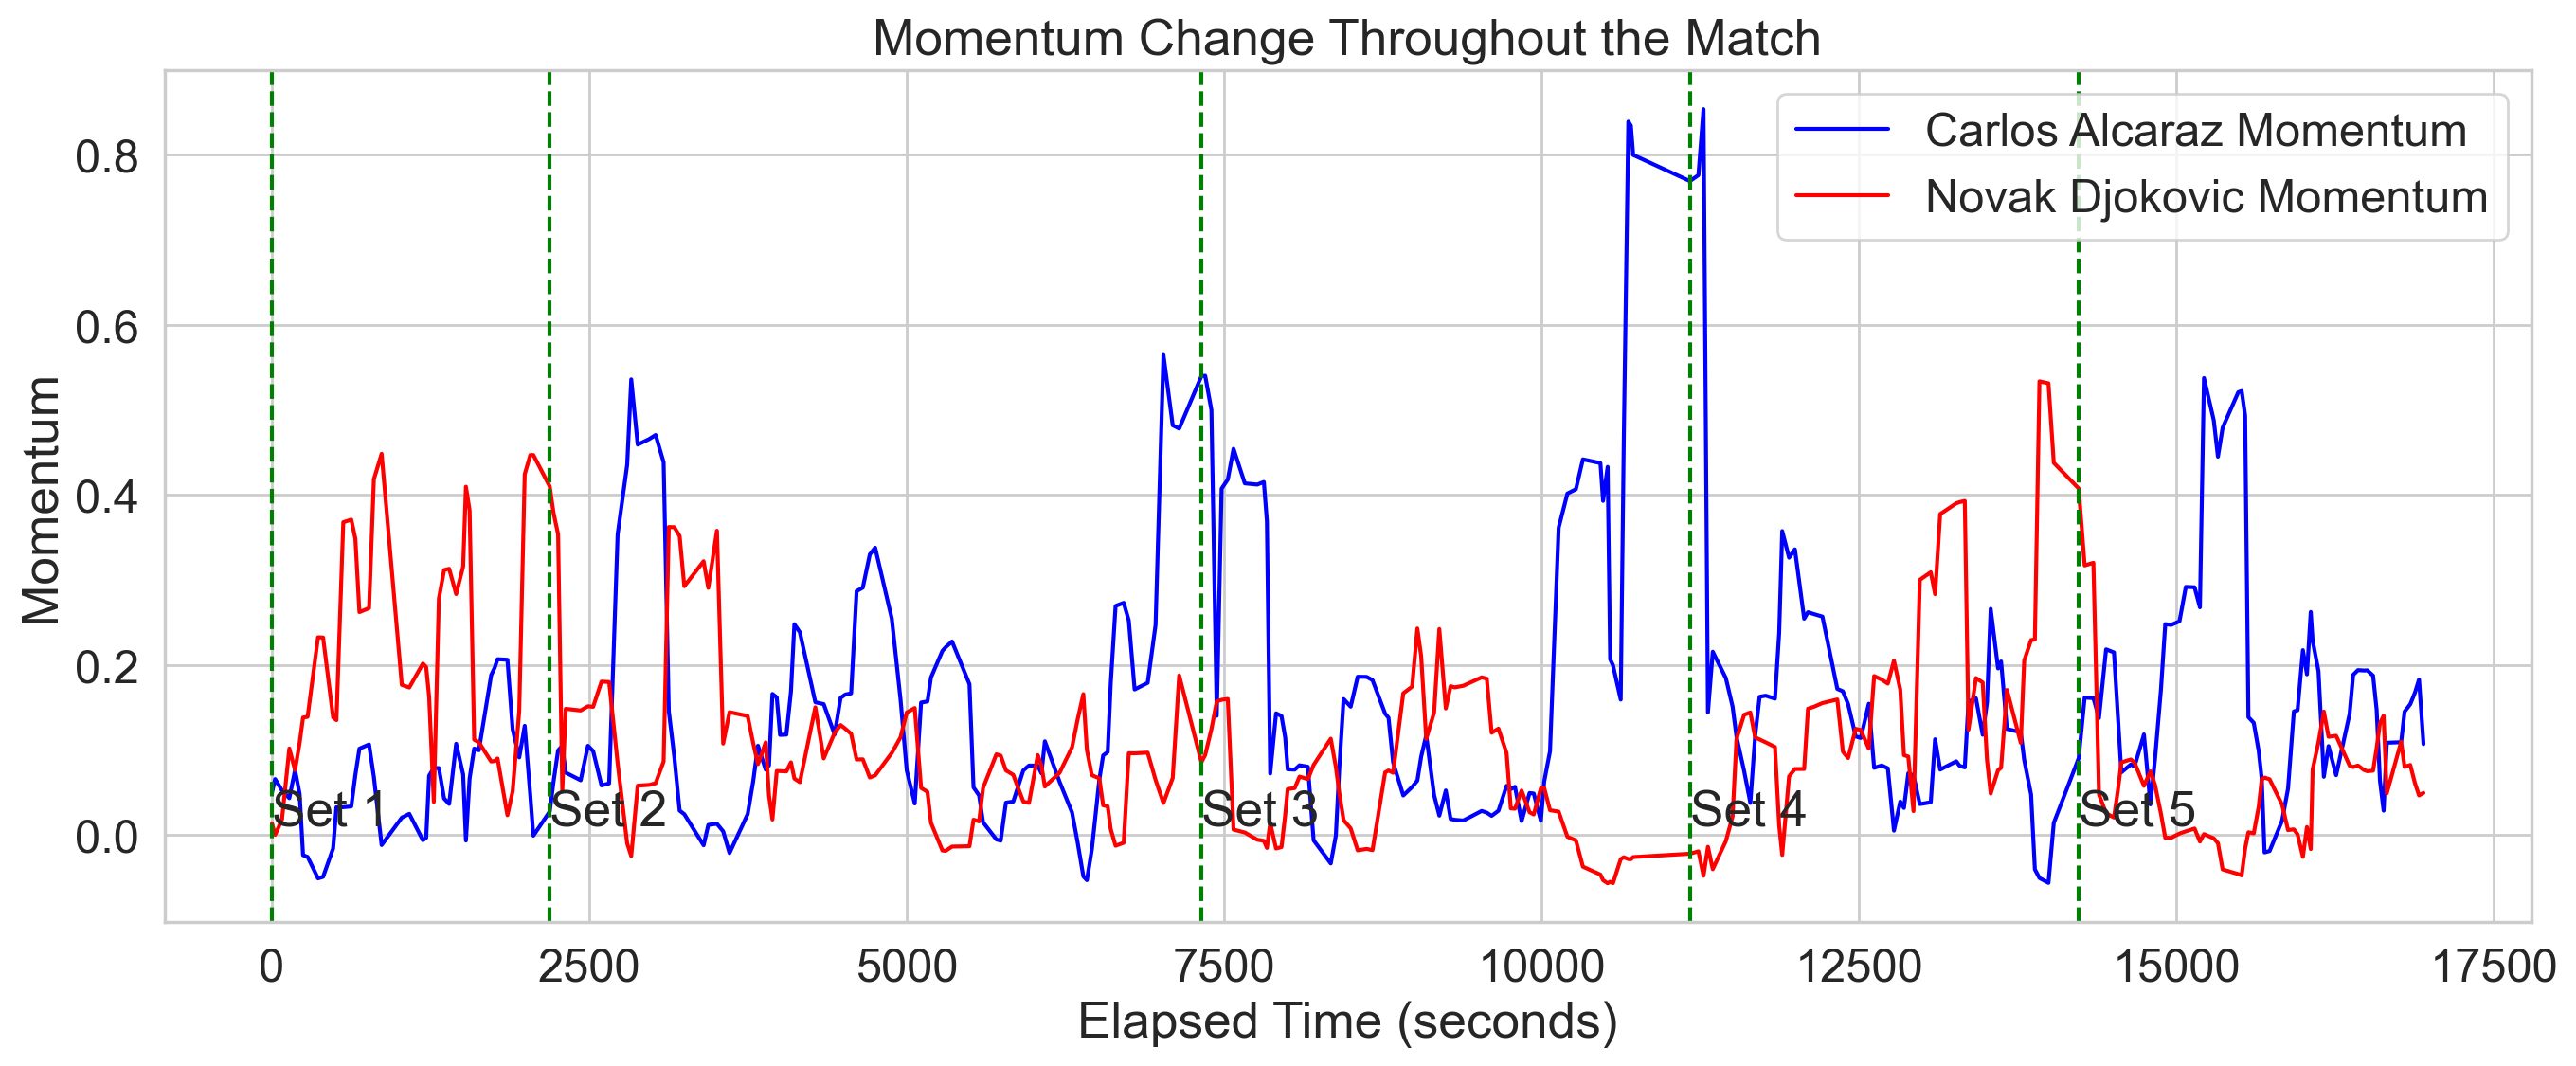

In [34]:
elapsed_seconds = temp['elapsed_time'].apply(lambda x: sum(int(a) * 60**index for index, a in enumerate(reversed(x.split(":")))))

temp['elapsed_seconds'] = elapsed_seconds

plt.figure(figsize=(14, 6))

plt.plot(elapsed_seconds, temp['p1_momentum'], label=temp['player1'].iloc[0] + " Momentum", color='blue')
plt.plot(elapsed_seconds, temp['p2_momentum'], label=temp['player2'].iloc[0] + " Momentum", color='red')

# Horizontal line to show the start of each set
for i in range(1, temp['set_no'].max() + 1):
    plt.axvline(x=temp[temp['set_no'] == i].iloc[0]['elapsed_seconds'], color='green', linestyle='--')
    plt.text(temp[temp['set_no'] == i].iloc[0]['elapsed_seconds'], 0, 'Set ' + str(i), verticalalignment='bottom')

plt.legend()

plt.title('Momentum Change Throughout the Match')
plt.xlabel('Elapsed Time (seconds)')
plt.ylabel('Momentum')

plt.grid(True)
plt.tight_layout()

plt.show()

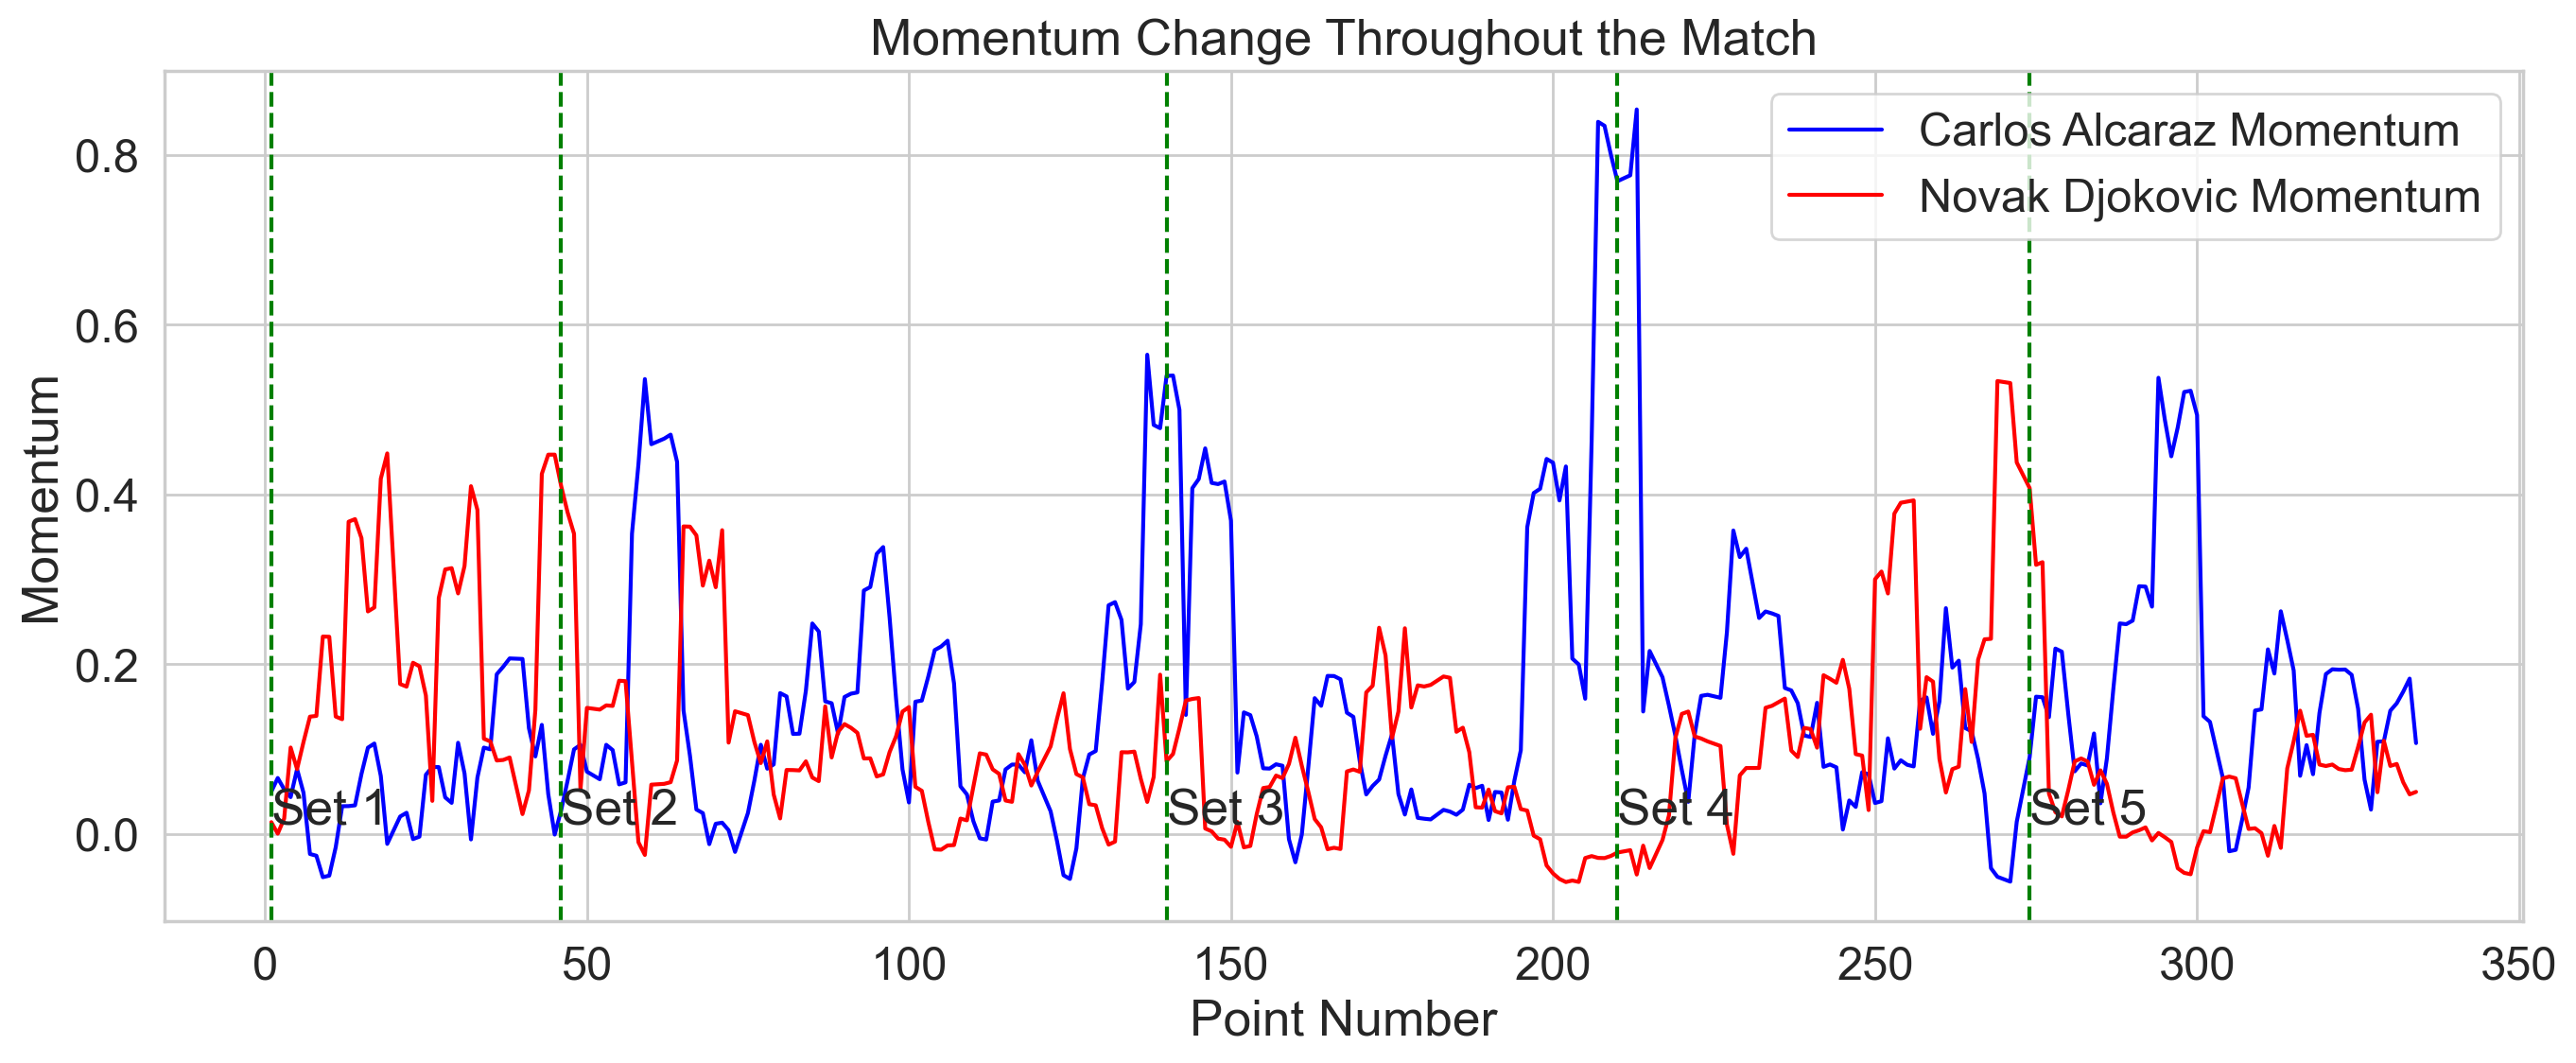

In [35]:
# Plot the monentum of player 1 and player 2 based on points
plt.figure(figsize=(14, 6))

plt.plot(temp['point_no'], temp['p1_momentum'], label=temp['player1'].iloc[0] + " Momentum", color='blue')
plt.plot(temp['point_no'], temp['p2_momentum'], label=temp['player2'].iloc[0] + " Momentum", color='red')

# Horizontal line to show the start of each set
for i in range(1, temp['set_no'].max() + 1):
    plt.axvline(x=temp[temp['set_no'] == i].iloc[0]['point_no'], color='green', linestyle='--')
    plt.text(temp[temp['set_no'] == i].iloc[0]['point_no'], 0, 'Set ' + str(i), verticalalignment='bottom')

plt.legend()

plt.title('Momentum Change Throughout the Match')
plt.xlabel('Point Number')
plt.ylabel('Momentum')

plt.grid(True)
plt.tight_layout()

plt.show()

In [36]:
# Calculate the turning points
p1_turning_points = cumsum_detection(temp['p1_momentum'])
p2_turning_points = cumsum_detection(temp['p2_momentum'])
temp['p1_momentum']

0      0.049797
1      0.065809
2      0.052511
3      0.043319
4      0.076306
         ...   
316    0.145122
317    0.153872
318    0.167501
319    0.182961
320    0.106977
Name: p1_momentum, Length: 321, dtype: float64

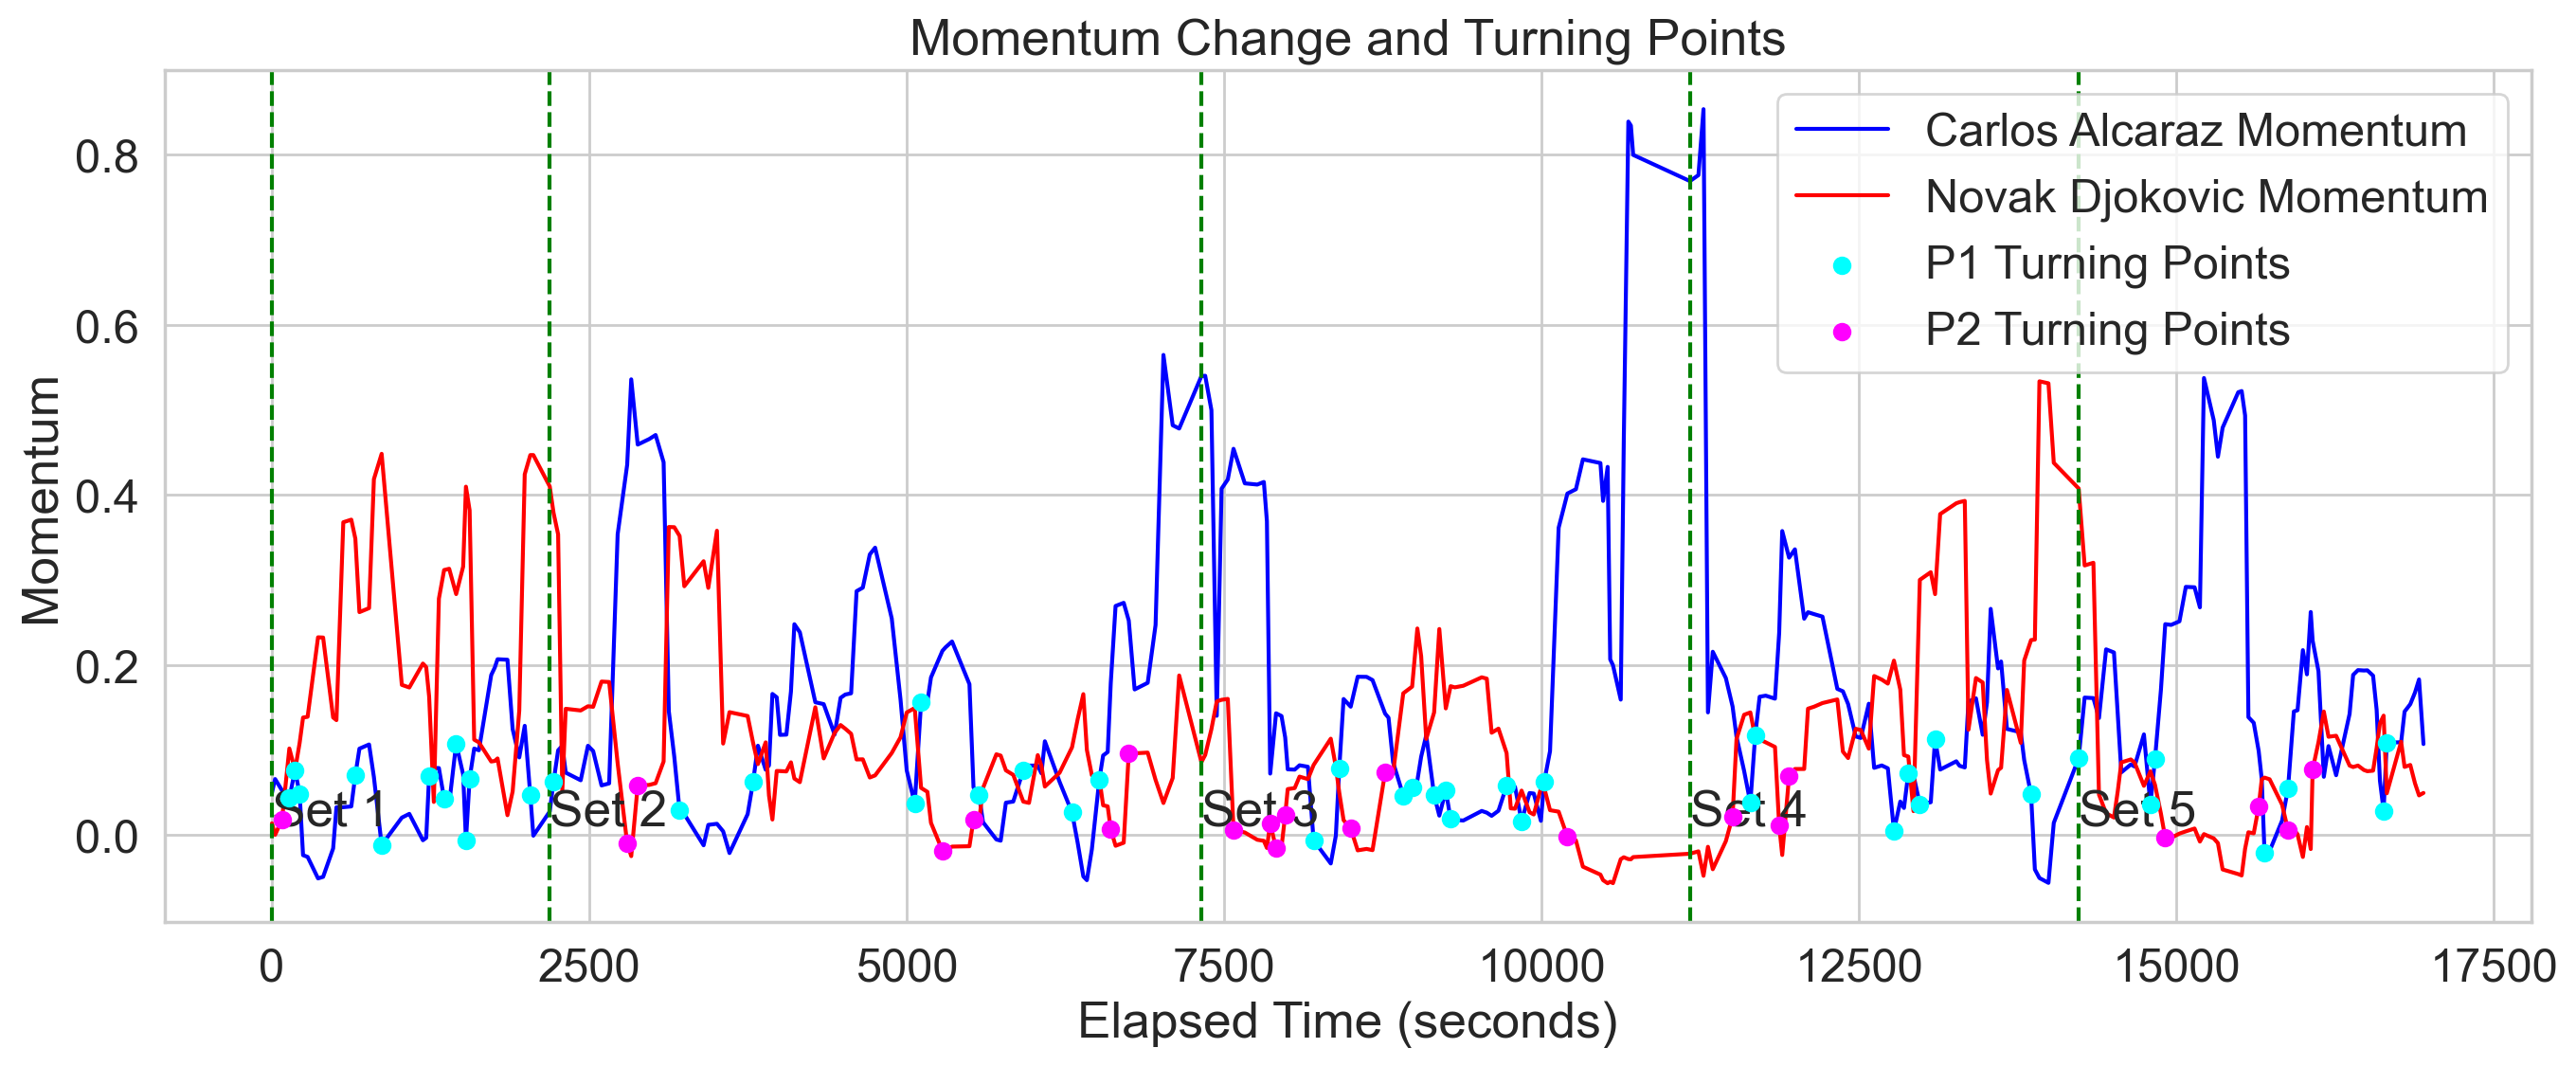

In [37]:
plt.figure(figsize=(14, 6))
plt.plot(elapsed_seconds, temp['p1_momentum'], label=temp['player1'].iloc[0] + " Momentum", color='blue')
plt.plot(elapsed_seconds, temp['p2_momentum'], label=temp['player2'].iloc[0] + " Momentum", color='red')

plt.scatter(elapsed_seconds.iloc[p1_turning_points], temp['p1_momentum'].iloc[p1_turning_points], color='cyan', label='P1 Turning Points', zorder=5)
plt.scatter(elapsed_seconds.iloc[p2_turning_points], temp['p2_momentum'].iloc[p2_turning_points], color='magenta', label='P2 Turning Points', zorder=5)

for i in range(1, temp['set_no'].max() + 1):
    plt.axvline(x=temp[temp['set_no'] == i].iloc[0]['elapsed_seconds'], color='green', linestyle='--')
    plt.text(temp[temp['set_no'] == i].iloc[0]['elapsed_seconds'], 0, 'Set ' + str(i), verticalalignment='bottom')

plt.legend()
plt.title('Momentum Change and Turning Points')
plt.xlabel('Elapsed Time (seconds)')
plt.ylabel('Momentum')
plt.grid(True)
plt.tight_layout()
plt.show()

In [129]:
categorical_variables = ['winner_shot_type','serve_width','serve_depth']
temp_1=pd.get_dummies(df_momentum[categorical_variables])

# Dataframe with only p1_momentum and p2_momentum
temp_2 = df_momentum[['p1_momentum','p2_momentum']]

temp_3 = data_point_based.copy()
data = pd.DataFrame()
data['match_id'] = df_momentum['match_id']
data = pd.concat([data,temp_2,temp_3],axis=1)


In [130]:
# Calculate the momentum difference percentage
data['p1_momentum_diff1']=data['p1_momentum'].diff(1)

# backfill the missing value
data['p1_momentum_diff1'].fillna(method='backfill',inplace=True)

In [131]:
data=data.dropna()
data.reset_index(inplace=True,drop=True)

In [132]:
match_id = data.match_id.unique()

In [133]:
train_id, test_id = train_test_split(match_id, test_size=0.2)

train = data[data['match_id'].isin(train_id)]
test = data[data['match_id'].isin(test_id)]

X_train = train.drop(['match_id','p1_momentum_diff1','p1_momentum', 'p2_momentum'],axis=1)
y_train = train['p1_momentum_diff1']

X_test = test.drop(['match_id','p1_momentum_diff1', 'p1_momentum', 'p2_momentum'],axis=1)
y_test = test['p1_momentum_diff1']

X_train.columns

Index(['gameWon', 'pointLeadG', 'gameLeadS', 'setLeadM', 'ifServing', 'ace',
       'winner', 'dFault', 'unforcedE', 'netPoints', 'breakPoints',
       'distanceM', 'distanceLast3', 'distanceCur', 'speed', 'trueSpeed',
       'rallyCur', 'rallyLast3', 'pointsLast3', 'point_label'],
      dtype='object')

In [134]:
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual))

In [135]:
xgb_model = xgb.XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.05, objective='reg:squarederror')
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

# Calculate the mean absolute percentage error
mape(y_test, y_pred)

6.535025409963428

2023-wimbledon-1601
2023-wimbledon-1312
2023-wimbledon-1307
2023-wimbledon-1503
2023-wimbledon-1406
2023-wimbledon-1313


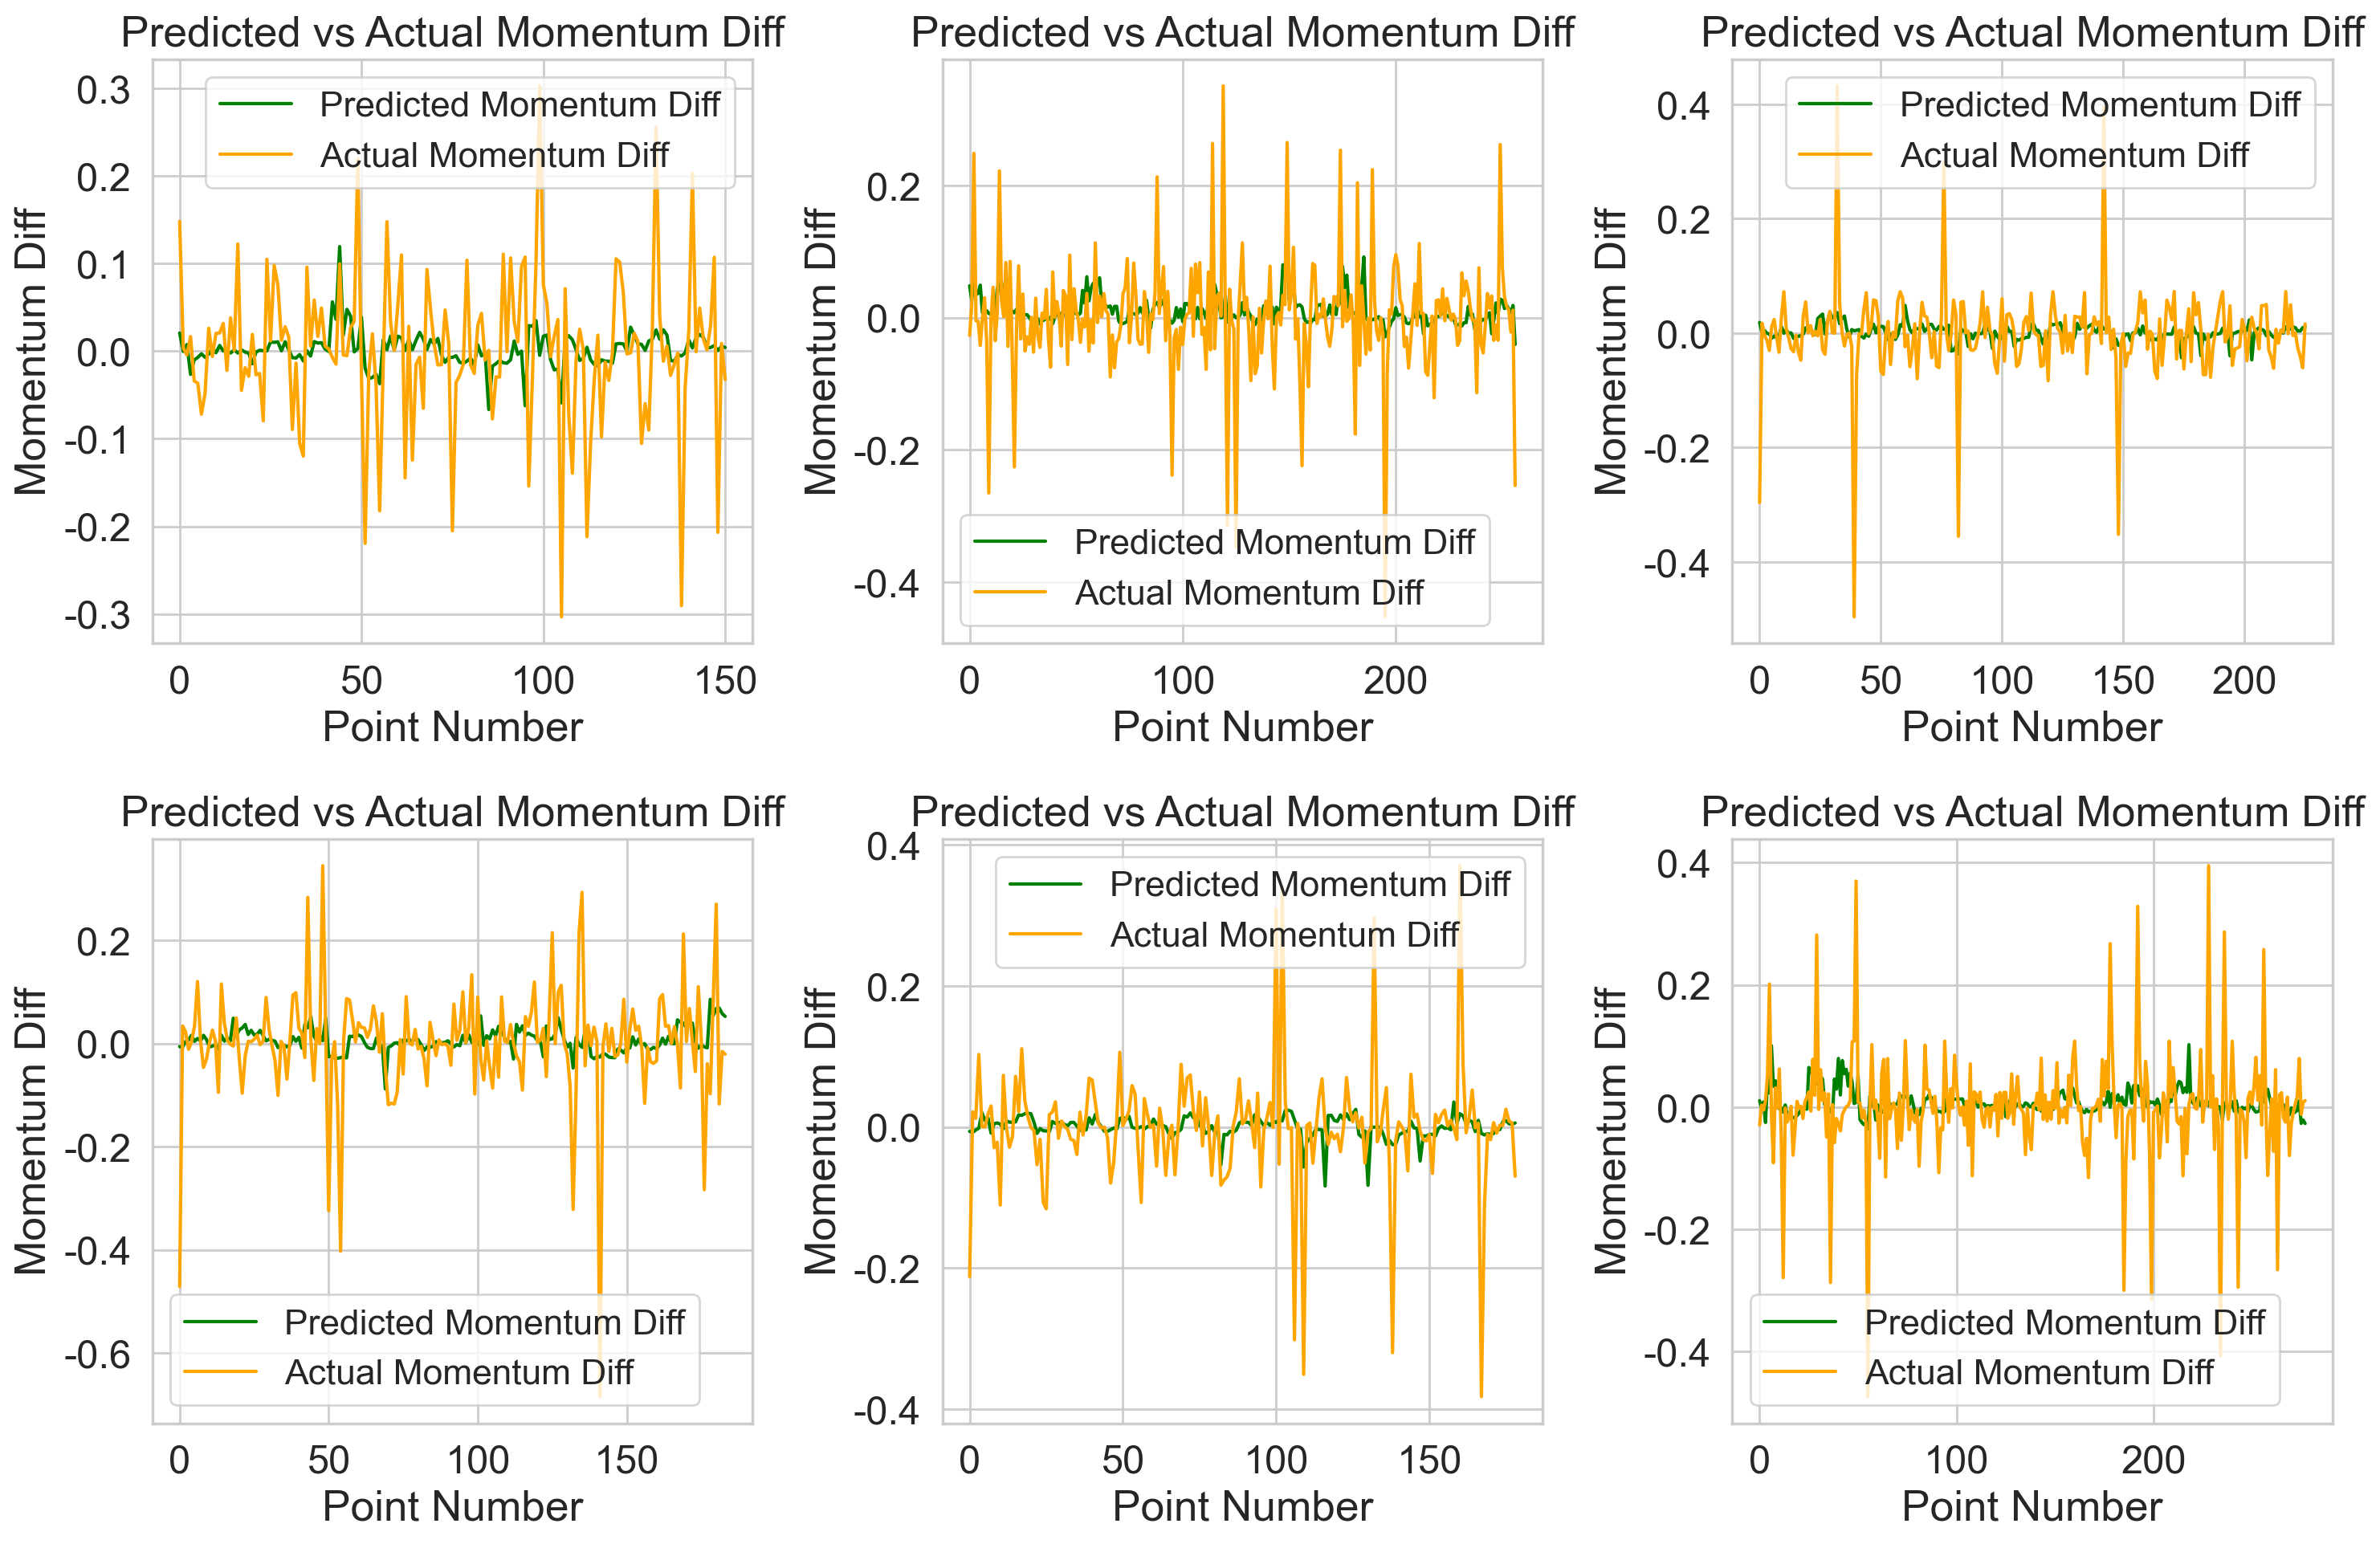

In [115]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

for col_idx, match_id in enumerate(test_id):
    row_idx = 0

    if col_idx > 2:
        col_idx = col_idx - 3
        row_idx += 1

    print(match_id)

    match_data = data[data['match_id'] == match_id].copy()

    match_data.reset_index(inplace=True,drop=True)

    X = match_data.drop(['match_id','p1_momentum_diff1','p1_momentum', 'p2_momentum'],axis=1)
    y = match_data['p1_momentum_diff1']
    y_pred = xgb_model.predict(X)
    y_test = y_test.reset_index(drop=True)

    # plot the predicted momentum difference
    axs[row_idx, col_idx].plot(y_pred, label='Predicted Momentum Diff', color='green')
    axs[row_idx, col_idx].plot(y, label='Actual Momentum Diff', color='orange')
    axs[row_idx, col_idx].set_title('Predicted vs Actual Momentum Diff')
    axs[row_idx, col_idx].set_xlabel('Point Number')
    axs[row_idx, col_idx].set_ylabel('Momentum Diff')
    axs[row_idx, col_idx].legend(fontsize = 'small')

plt.tight_layout()
plt.show()

In [46]:
import shap

In [136]:
explainer = shap.TreeExplainer(xgb_model)
explanation = explainer(X_test)

shap_values = explanation.values
# make sure the SHAP values add up to marginal predictions
np.abs(shap_values.sum(axis=1) + explanation.base_values - y_pred).max()

8.568168e-08

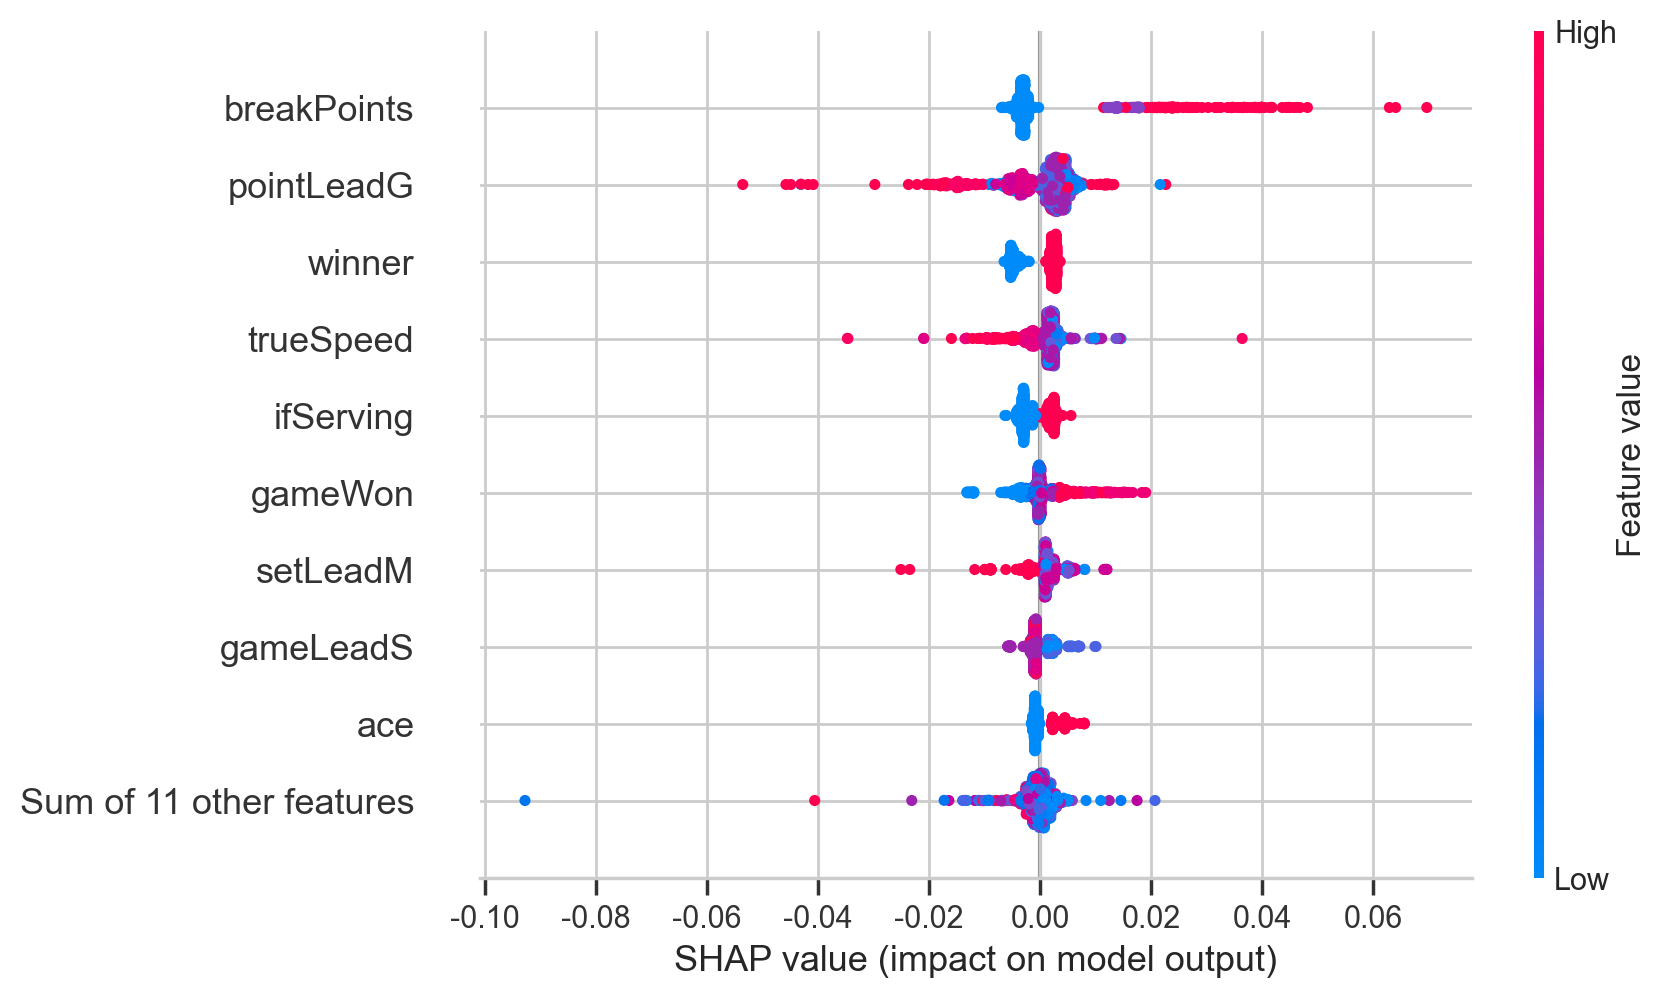

In [137]:
shap.plots.beeswarm(explanation)

In [118]:
# Use CNN-LSTM model to predict the momentum difference
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Flatten, TimeDistributed
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

# Define the model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1],1)))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(50, activation='sigmoid', return_sequences=True))
model.add(LSTM(50, activation='sigmoid'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

# Fit the model
model.fit(X_train, y_train, epochs=100, verbose=1)

# Predict the momentum difference
y_pred = model.predict(X_test)

# Calculate the mean absolute percentage error
mape(y_test, y_pred)

Epoch 1/100
163/163 [==============================] - 3s 5ms/step - loss: 0.0096
Epoch 2/100
163/163 [==============================] - 1s 5ms/step - loss: 0.0055
Epoch 3/100
163/163 [==============================] - 1s 6ms/step - loss: 0.0055
Epoch 4/100
163/163 [==============================] - 1s 5ms/step - loss: 0.0055
Epoch 5/100
163/163 [==============================] - 1s 5ms/step - loss: 0.0054
Epoch 6/100
163/163 [==============================] - 1s 6ms/step - loss: 0.0055
Epoch 7/100
163/163 [==============================] - 1s 5ms/step - loss: 0.0057
Epoch 8/100
163/163 [==============================] - 1s 5ms/step - loss: 0.0055
Epoch 9/100
163/163 [==============================] - 1s 5ms/step - loss: 0.0055
Epoch 10/100
163/163 [==============================] - 1s 5ms/step - loss: 0.0056
Epoch 11/100
163/163 [==============================] - 1s 6ms/step - loss: 0.0055
Epoch 12/100
163/163 [==============================] - 1s 5ms/step - loss: 0.0057
Epoch 13/100


4.407832063317648

2023-wimbledon-1601
2023-wimbledon-1312
2023-wimbledon-1307
2023-wimbledon-1503
2023-wimbledon-1406
2023-wimbledon-1313


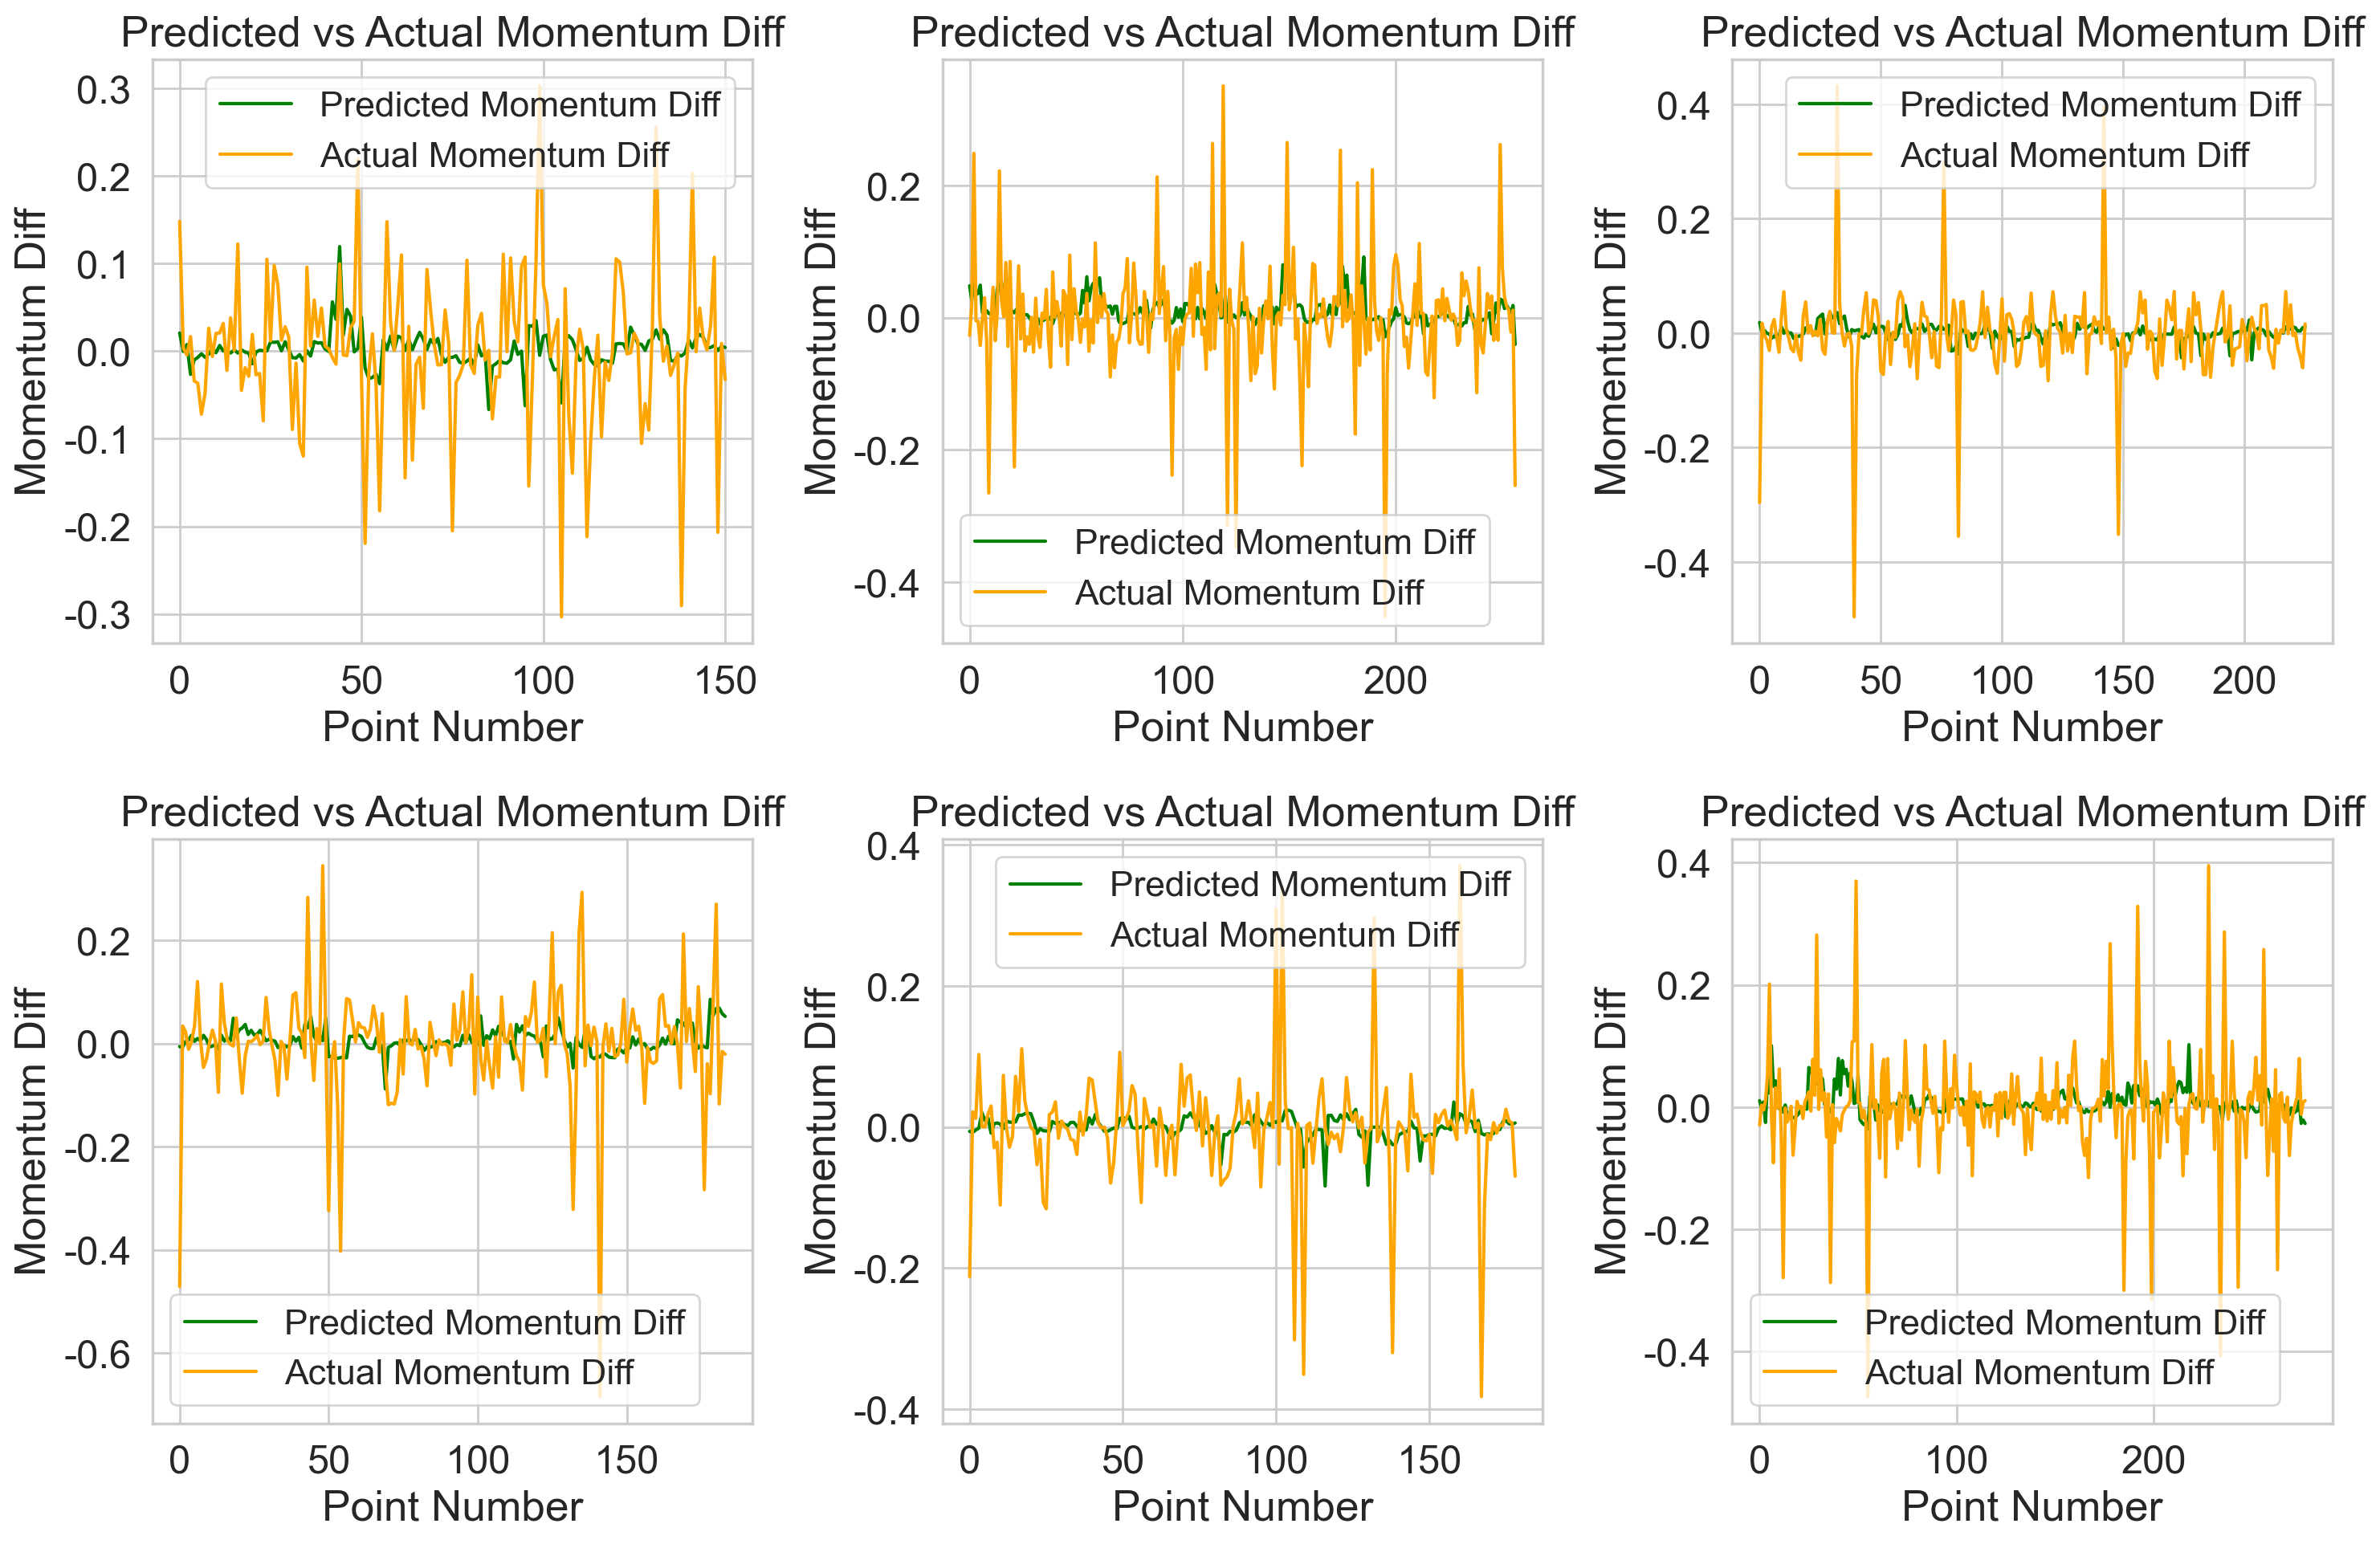

In [119]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

for col_idx, match_id in enumerate(test_id):
    row_idx = 0

    if col_idx > 2:
        col_idx = col_idx - 3
        row_idx += 1

    print(match_id)

    match_data = data[data['match_id'] == match_id].copy()

    match_data.reset_index(inplace=True,drop=True)

    X = match_data.drop(['match_id','p1_momentum_diff1','p1_momentum', 'p2_momentum'],axis=1)
    y = match_data['p1_momentum_diff1']
    y_pred = xgb_model.predict(X)
    y_test = y_test.reset_index(drop=True)

    # plot the predicted momentum difference
    axs[row_idx, col_idx].plot(y_pred, label='Predicted Momentum Diff', color='green')
    axs[row_idx, col_idx].plot(y, label='Actual Momentum Diff', color='orange')
    axs[row_idx, col_idx].set_title('Predicted vs Actual Momentum Diff')
    axs[row_idx, col_idx].set_xlabel('Point Number')
    axs[row_idx, col_idx].set_ylabel('Momentum Diff')
    axs[row_idx, col_idx].legend(fontsize = 'small')

plt.tight_layout()
plt.show()

In [51]:
data

match_id  p1_momentum  p2_momentum   gameWon  pointLeadG  \
0     2023-wimbledon-1301     0.093343     0.020962  0.000000      0.5000   
1     2023-wimbledon-1301     0.206826     0.013676  0.000000      0.3125   
2     2023-wimbledon-1301     0.201867     0.022111  0.000000      0.5000   
3     2023-wimbledon-1301     0.316151     0.016316  0.000000      0.3125   
4     2023-wimbledon-1301     0.322319     0.060254  0.000000      0.5000   
...                   ...          ...          ...       ...         ...   
6480  2023-wimbledon-1701     0.145122     0.080071  0.833333      0.3125   
6481  2023-wimbledon-1701     0.153872     0.082380  0.833333      0.5000   
6482  2023-wimbledon-1701     0.167501     0.060882  0.833333      0.6875   
6483  2023-wimbledon-1701     0.182961     0.046578  0.833333      0.5000   
6484  2023-wimbledon-1701     0.106977     0.049493  0.833333      0.6250   

      gameLeadS  setLeadM  ifServing  ace  winner  ...  distanceM  \
0      0.555556       0.5        1.0  1.0     1.0  ...   0.000830   
1      0.555556       0.5        1.0  1.0     1.0  ...   0.001663   
2      0.555556       0.5        1.0  1.0     1.0  ...   0.003875   
3      0.555556       0.5        1.0  1.0     1.0  ...   0.012104   
4      0.555556       0.5        1.0  1.0     1.0  ...   0.012195   
...         ...       ...        ...  ...     ...  ...        ...   
6480   0.666667       0.5        1.0  0.0     1.0  ...   0.991328   
6481   0.666667       0.5        1.0  0.0     1.0  ...   0.994142   
6482   0.666667       0.5        1.0  0.0     1.0  ...   0.995883   
6483   0.666667       0.5        1.0  0.0     1.0  ...   0.997141   
6484   0.666667       0.5        1.0  0.0     1.0  ...   1.000000   

      distanceLast3  distanceCur     speed  trueSpeed  rallyCur  rallyLast3  \
0          0.000000     0.061495  0.333333   0.563199       0.0    0.000000   
1          0.000000     0.053722  0.666667   0.563199       0.0    0.041667   
2          0.150271     0.142655  0.695652   0.563199       0.0    0.111111   
3          0.423782     0.530851  0.840580   0.563199       0.0    0.416667   
4          0.395866     0.005816  0.579710   0.563199       0.0    0.416667   
...             ...          ...       ...        ...       ...         ...   
6480       0.298759     0.400911  0.739130   0.668960       0.0    0.305556   
6481       0.379907     0.181498  0.608696   0.661221       0.0    0.416667   
6482       0.404828     0.112293  0.753623   0.669819       0.0    0.472222   
6483       0.218515     0.081192  0.840580   0.674979       0.0    0.194444   
6484       0.220201     0.184390  0.826087   0.674119       0.0    0.138889   

      pointsLast3  point_label  p1_momentum_diff1  
0             0.0            0           0.113483  
1             0.1            1           0.113483  
2             0.1            0          -0.004959  
3             0.1            1           0.114283  
4             0.2            1           0.006168  
...           ...          ...                ...  
6480          0.1            1           0.035999  
6481          0.2            1           0.008750  
6482          0.1            0           0.013629  
6483          0.1            1           0.015459  
6484          0.2            1          -0.075983  

[6485 rows x 24 columns]

In [53]:
match_id = '2023-wimbledon-1701'
match_data = data[data['match_id'] == match_id].copy()

match_data.reset_index(inplace=True,drop=True)

X = match_data.drop(['match_id','p1_momentum_diff1','p1_momentum', 'p2_momentum'],axis=1)
y = match_data['p1_momentum_diff1']

# Select the first 80% of the data as the training set
X_train = X.iloc[:int(len(X)*0.8)]
y_train = y.iloc[:int(len(X)*0.8)]

# Select the last 20% of the data as the test set
X_test = X.iloc[int(len(X)*0.8):]
y_test = y.iloc[int(len(X)*0.8):]

xgb_model = xgb.XGBRegressor(n_estimators=80, max_depth=5, learning_rate=0.1, objective='reg:squarederror')
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

y_test = y_test.reset_index(drop=True)

# Calculate the mean absolute percentage error
mape(y_test, y_pred)

8.475507081116474

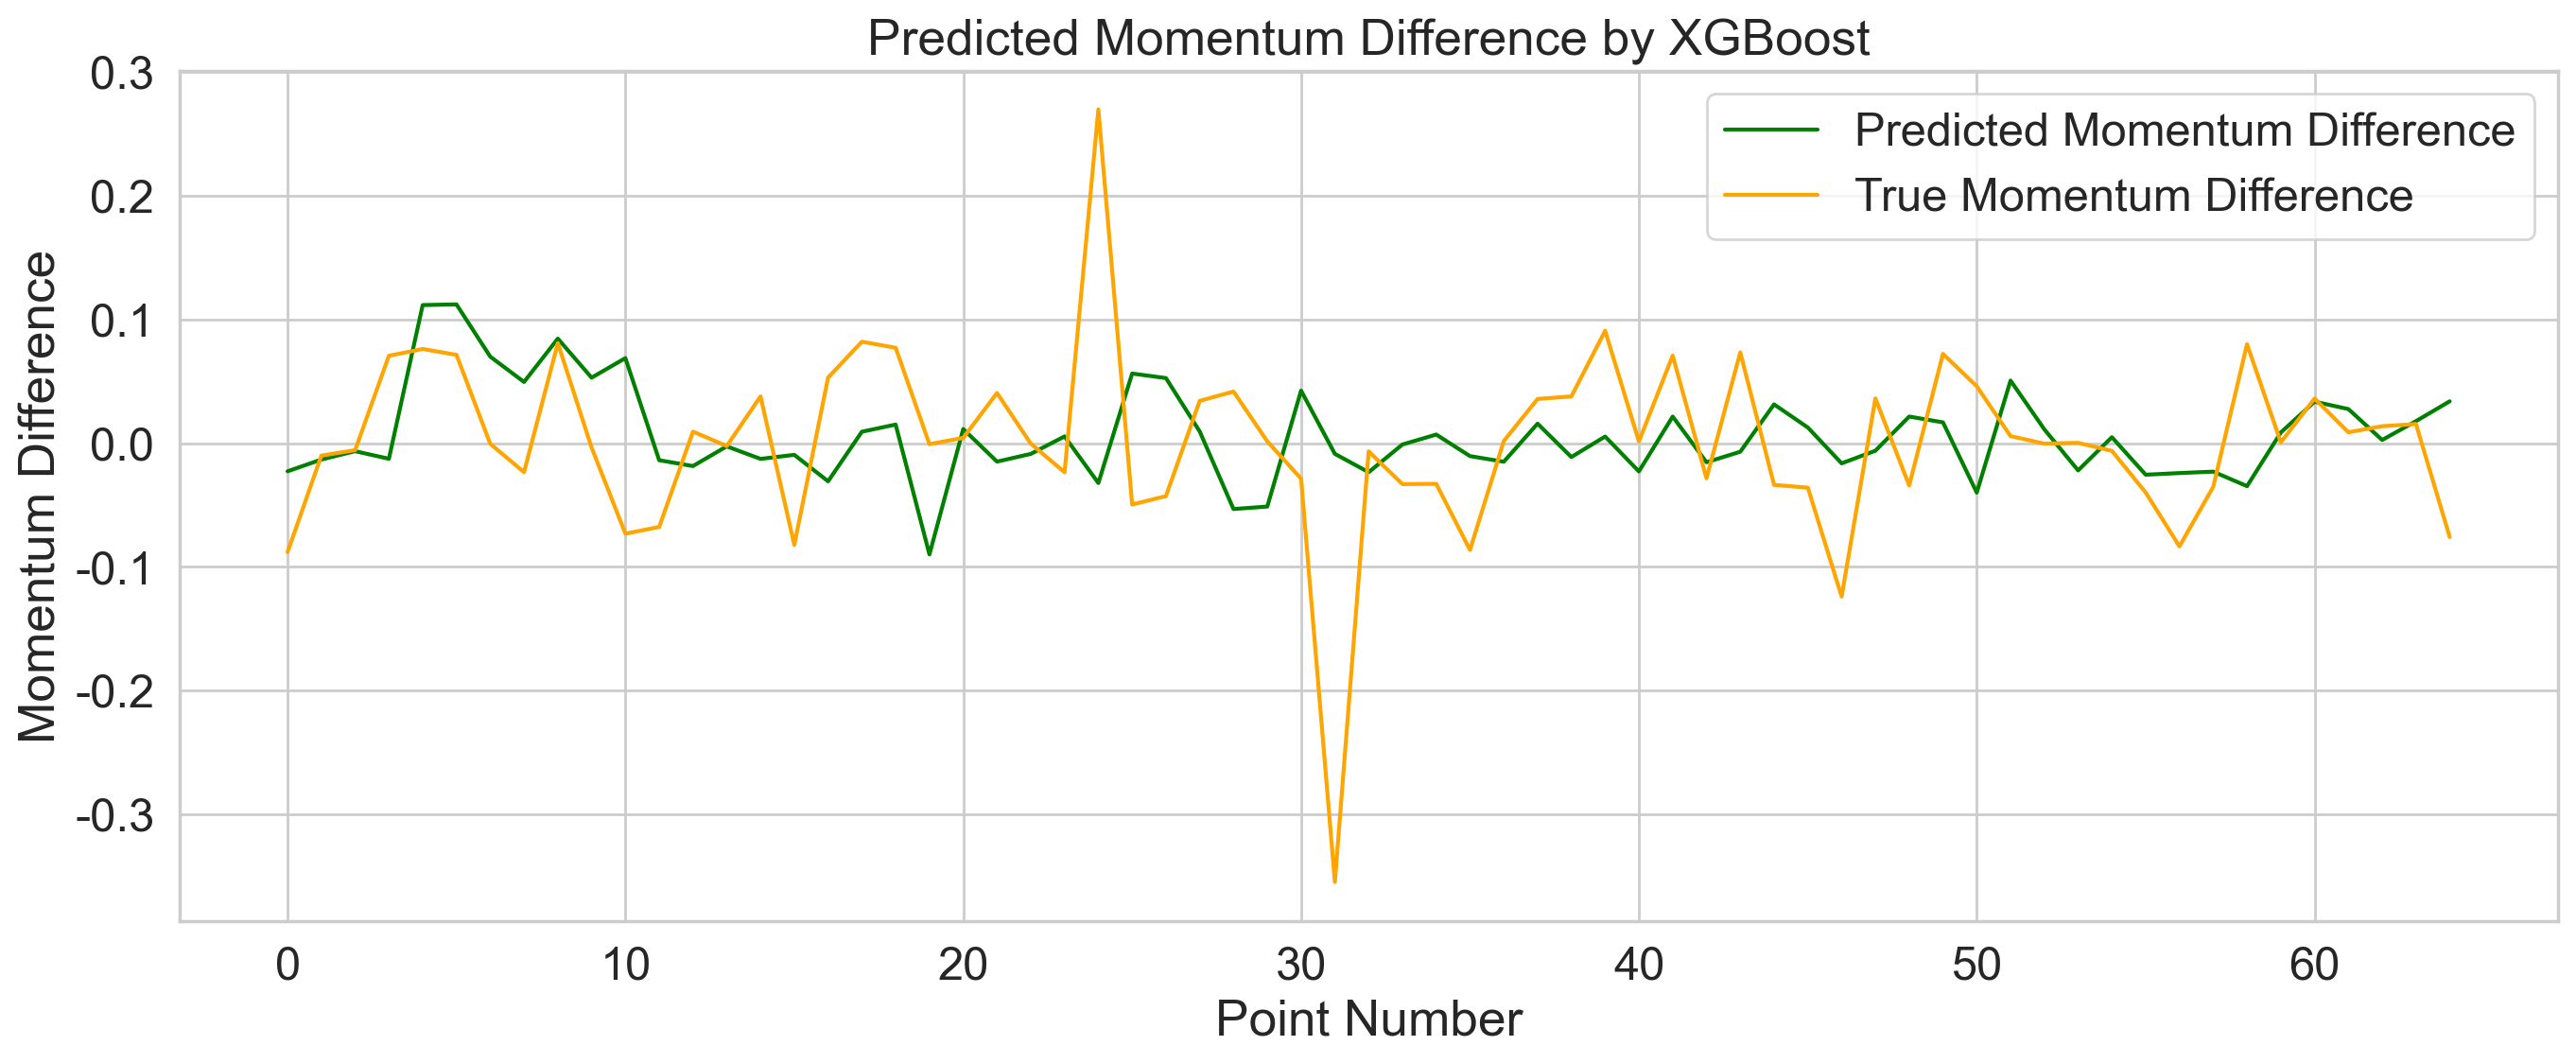

In [54]:
# plot the predicted momentum difference
plt.figure(figsize=(14, 6))
plt.plot(y_pred, label='Predicted Momentum Difference', color='green')
plt.plot(y_test, label='True Momentum Difference', color='orange')
plt.xlabel('Point Number')
plt.ylabel('Momentum Difference')
plt.title('Predicted Momentum Difference by XGBoost')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [124]:
explainer = shap.TreeExplainer(xgb_model)
explanation = explainer(X_test)

shap_values = explanation.values
# make sure the SHAP values add up to marginal predictions
np.abs(shap_values.sum(axis=1) + explanation.base_values - y_pred).max()

2.333395004272461

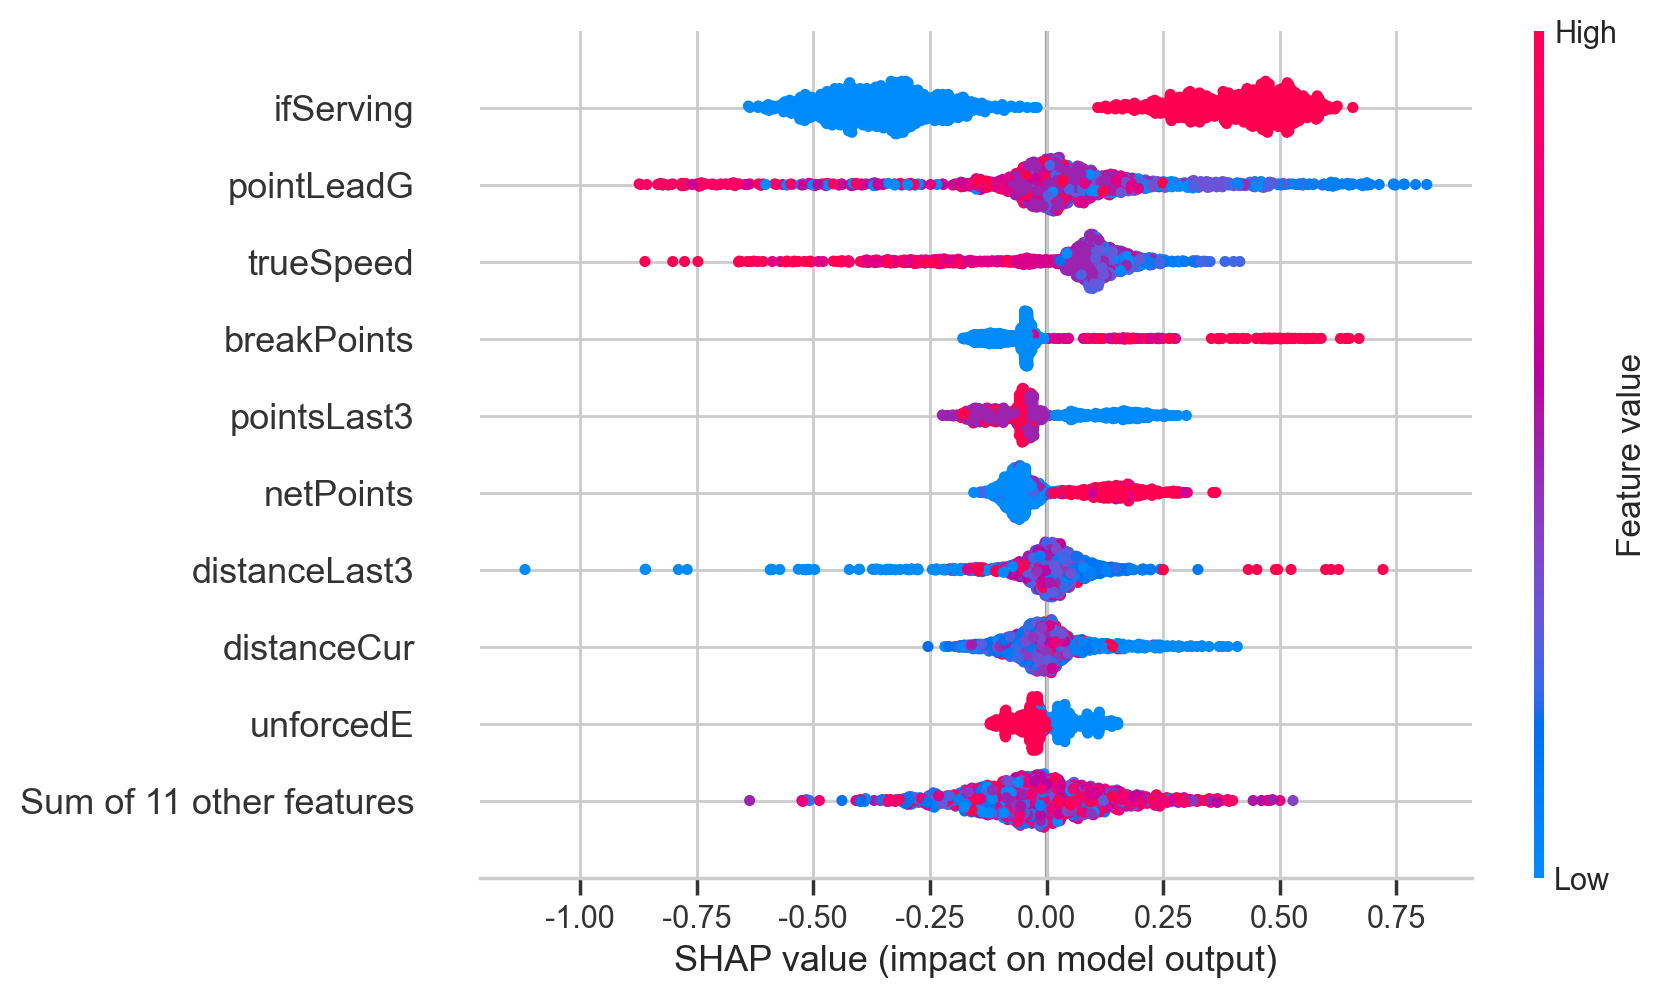

In [125]:
shap.plots.beeswarm(explanation)

In [57]:
# Define the model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1],1)))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(50, activation='sigmoid', return_sequences=True))
model.add(LSTM(50, activation='sigmoid'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

# Fit the model
model.fit(X_train, y_train, epochs=100, verbose=1)

# Predict the momentum difference
y_pred = model.predict(X_test)

# Calculate the mean absolute percentage error
mape(y_test, y_pred)

Epoch 1/100
8/8 [==============================] - 1s 6ms/step - loss: 0.2496
Epoch 2/100
8/8 [==============================] - 0s 5ms/step - loss: 0.0389
Epoch 3/100
8/8 [==============================] - 0s 5ms/step - loss: 0.0367
Epoch 4/100
8/8 [==============================] - 0s 4ms/step - loss: 0.0098
Epoch 5/100
8/8 [==============================] - 0s 4ms/step - loss: 0.0136
Epoch 6/100
8/8 [==============================] - 0s 4ms/step - loss: 0.0081
Epoch 7/100
8/8 [==============================] - 0s 4ms/step - loss: 0.0086
Epoch 8/100
8/8 [==============================] - 0s 4ms/step - loss: 0.0075
Epoch 9/100
8/8 [==============================] - 0s 4ms/step - loss: 0.0076
Epoch 10/100
8/8 [==============================] - 0s 4ms/step - loss: 0.0074
Epoch 11/100
8/8 [==============================] - 0s 4ms/step - loss: 0.0075
Epoch 12/100
8/8 [==============================] - 0s 4ms/step - loss: 0.0074
Epoch 13/100
8/8 [==============================] - 0s 4ms/st

3.642623924530158

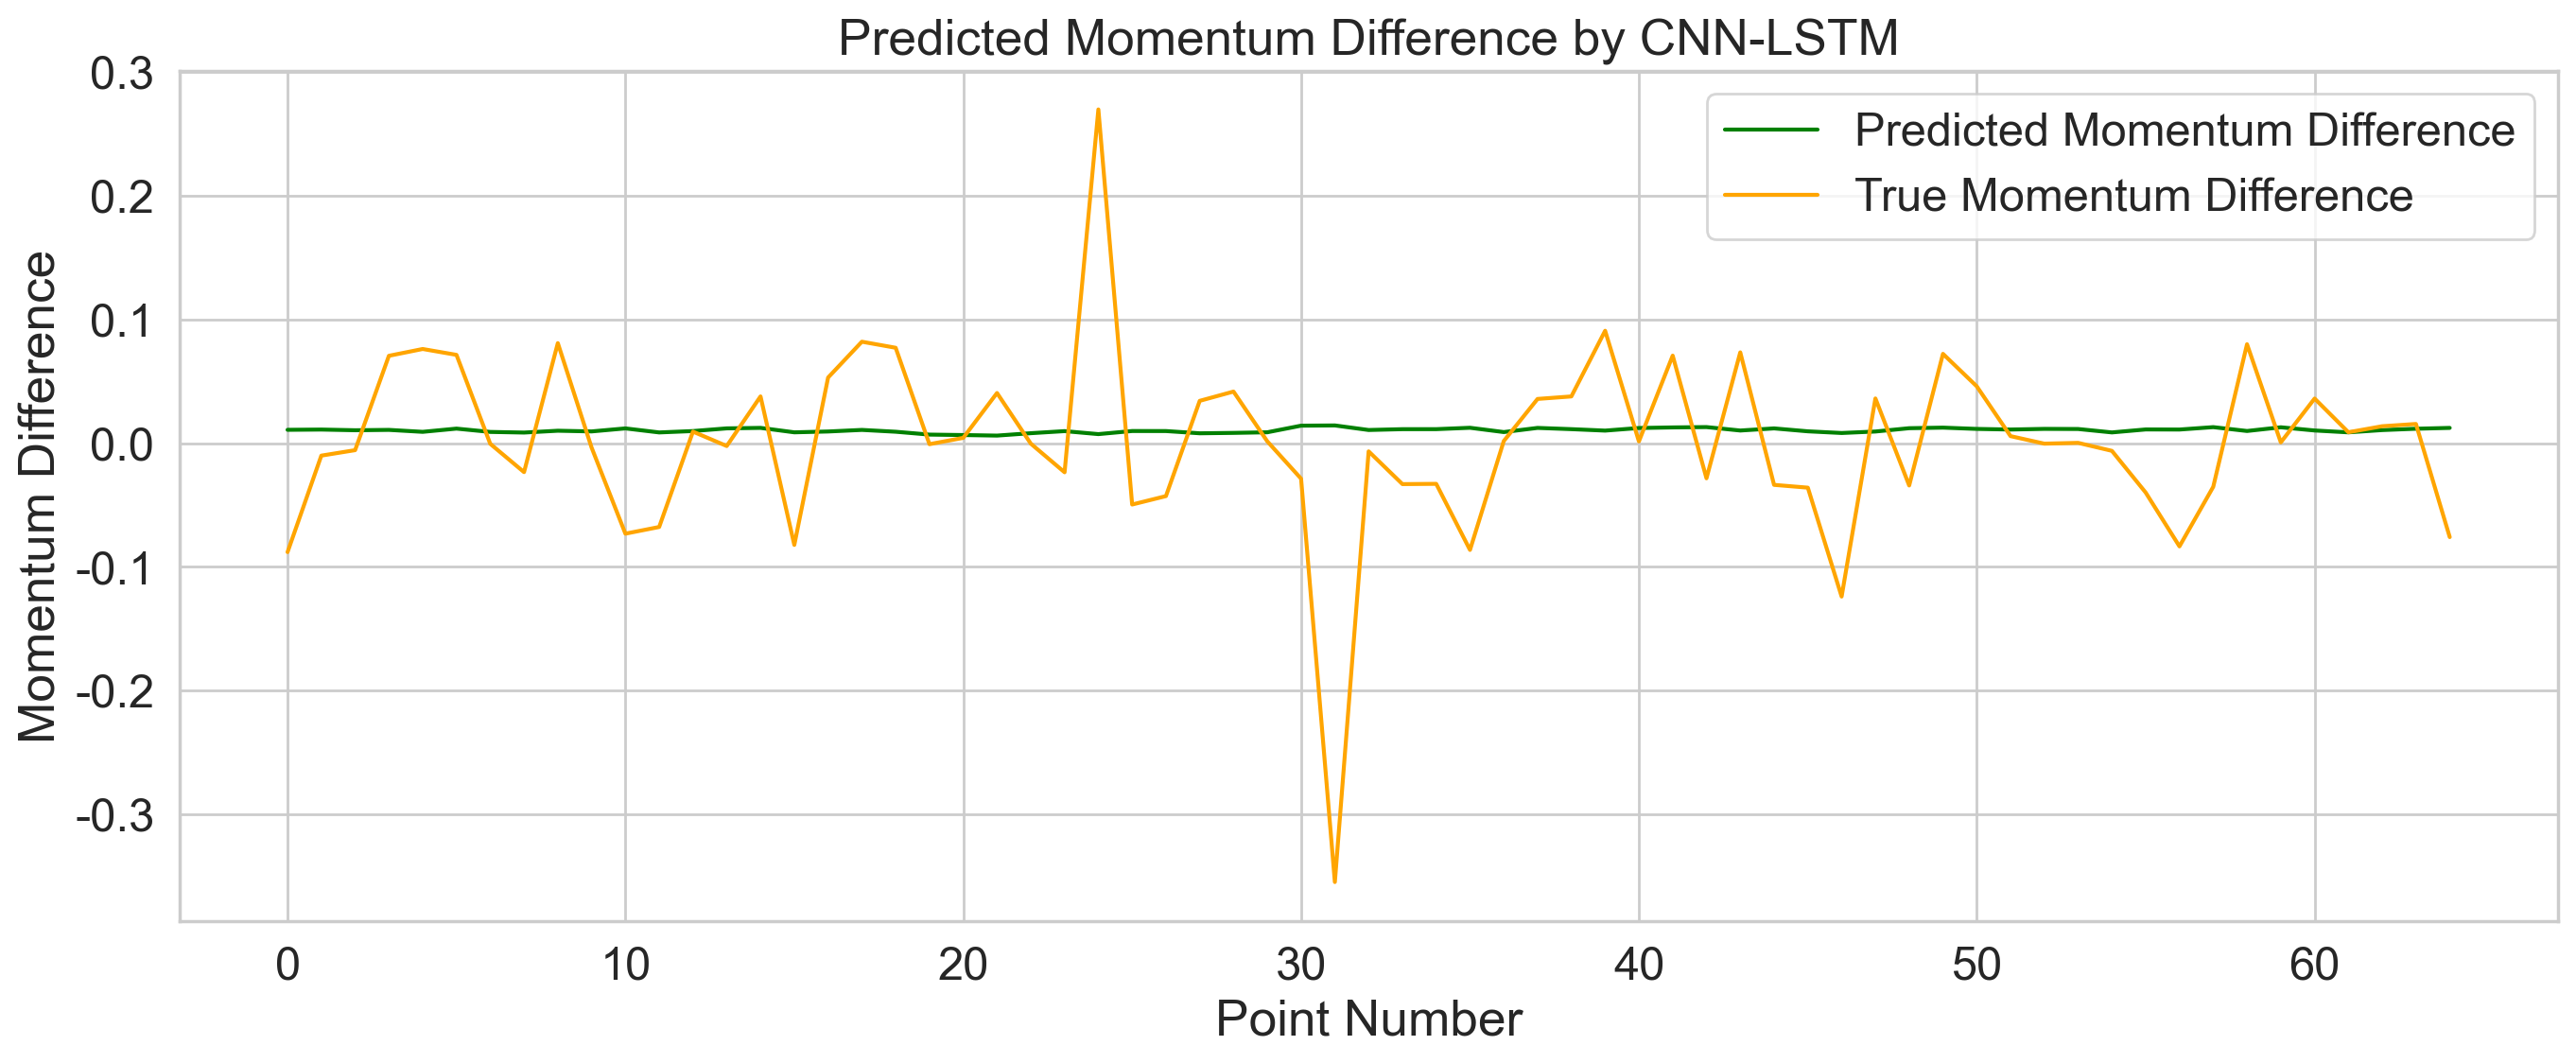

In [58]:
# plot the predicted momentum difference
plt.figure(figsize=(14, 6))
plt.plot(y_pred, label='Predicted Momentum Difference', color='green')
plt.plot(y_test, label='True Momentum Difference', color='orange')
plt.xlabel('Point Number')
plt.ylabel('Momentum Difference')
plt.title('Predicted Momentum Difference by CNN-LSTM')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [81]:
data

match_id  p1_momentum  p2_momentum   gameWon  pointLeadG  \
0     2023-wimbledon-1301     0.093343     0.020962  0.000000      0.5000   
1     2023-wimbledon-1301     0.206826     0.013676  0.000000      0.3125   
2     2023-wimbledon-1301     0.201867     0.022111  0.000000      0.5000   
3     2023-wimbledon-1301     0.316151     0.016316  0.000000      0.3125   
4     2023-wimbledon-1301     0.322319     0.060254  0.000000      0.5000   
...                   ...          ...          ...       ...         ...   
6480  2023-wimbledon-1701     0.145122     0.080071  0.833333      0.3125   
6481  2023-wimbledon-1701     0.153872     0.082380  0.833333      0.5000   
6482  2023-wimbledon-1701     0.167501     0.060882  0.833333      0.6875   
6483  2023-wimbledon-1701     0.182961     0.046578  0.833333      0.5000   
6484  2023-wimbledon-1701     0.106977     0.049493  0.833333      0.6250   

      gameLeadS  setLeadM  ifServing  ace  winner  ...  distanceM  \
0      0.555556       0.5        1.0  1.0     1.0  ...   0.000830   
1      0.555556       0.5        1.0  1.0     1.0  ...   0.001663   
2      0.555556       0.5        1.0  1.0     1.0  ...   0.003875   
3      0.555556       0.5        1.0  1.0     1.0  ...   0.012104   
4      0.555556       0.5        1.0  1.0     1.0  ...   0.012195   
...         ...       ...        ...  ...     ...  ...        ...   
6480   0.666667       0.5        1.0  0.0     1.0  ...   0.991328   
6481   0.666667       0.5        1.0  0.0     1.0  ...   0.994142   
6482   0.666667       0.5        1.0  0.0     1.0  ...   0.995883   
6483   0.666667       0.5        1.0  0.0     1.0  ...   0.997141   
6484   0.666667       0.5        1.0  0.0     1.0  ...   1.000000   

      distanceLast3  distanceCur     speed  trueSpeed  rallyCur  rallyLast3  \
0          0.000000     0.061495  0.333333   0.563199       0.0    0.000000   
1          0.000000     0.053722  0.666667   0.563199       0.0    0.041667   
2          0.150271     0.142655  0.695652   0.563199       0.0    0.111111   
3          0.423782     0.530851  0.840580   0.563199       0.0    0.416667   
4          0.395866     0.005816  0.579710   0.563199       0.0    0.416667   
...             ...          ...       ...        ...       ...         ...   
6480       0.298759     0.400911  0.739130   0.668960       0.0    0.305556   
6481       0.379907     0.181498  0.608696   0.661221       0.0    0.416667   
6482       0.404828     0.112293  0.753623   0.669819       0.0    0.472222   
6483       0.218515     0.081192  0.840580   0.674979       0.0    0.194444   
6484       0.220201     0.184390  0.826087   0.674119       0.0    0.138889   

      pointsLast3  point_label  p1_momentum_diff1  
0             0.0            0           0.113483  
1             0.1            1           0.113483  
2             0.1            0          -0.004959  
3             0.1            1           0.114283  
4             0.2            1           0.006168  
...           ...          ...                ...  
6480          0.1            1           0.035999  
6481          0.2            1           0.008750  
6482          0.1            0           0.013629  
6483          0.1            1           0.015459  
6484          0.2            1          -0.075983  

[6485 rows x 24 columns]

In [138]:
# Create a new column to indicate if the momentum difference is positive or negative
data['p1_momentum_diff'] = data['p1_momentum_diff1'].apply(lambda x: 1 if x > 0 else 0)

match_id = data.match_id.unique()

train_id, test_id = train_test_split(match_id, test_size=0.2)

train = data[data['match_id'].isin(train_id)]
test = data[data['match_id'].isin(test_id)]

X_train = train.drop(['match_id','p1_momentum_diff1','p1_momentum', 'p2_momentum','p1_momentum_diff'],axis=1)
y_train = train['p1_momentum_diff']

X_test = test.drop(['match_id','p1_momentum_diff1', 'p1_momentum', 'p2_momentum','p1_momentum_diff'],axis=1)
y_test = test['p1_momentum_diff']

In [139]:
xgb_model = xgb.XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.05, objective='binary:logistic')
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

# Calculate the accuracy
accuracy = (y_pred == y_test).sum() / len(y_test)
accuracy

0.6376021798365122